## Introduction:
Housing price of Ames City from Iowa is taken. Buying house is one of the toughest to do, we have to be sure and need to know about all the features of house that directly or indirectly effects the choice of buying that house. Here I am trying to see what features of house affects on sale price of house. If there is any dependent features to one another or only sale price is dependent to all features? I am using all the contents to see the performance of the model.
### Contents:
- Libraries
- EDA
- Data Exploration
- Feature Engineering/Selection
- Initial Modelling using linear regression
- Train/Test data
- Validating model
- Overfitting and Regularization
- Testing for model performance
- Conclusion

## Libraries:

In [427]:
#importing numpy, pandas, sklearn, pyplot, sqlalchemy 
import pandas as pd #for dataframe
import numpy as np #linear algebra libraries
import matplotlib.pyplot as plt #visualization
import seaborn as sns # seaborn for visualization
import math #statistics
import scipy.stats as stats #for ttest
from sklearn.preprocessing import StandardScaler # for standardization and normalization
from sklearn.decomposition import PCA #to reduce Linear dimensionality
from sklearn.preprocessing import normalize #for normalization
from sklearn.preprocessing import scale #for standardization
from sqlalchemy import create_engine # for open connection of SQL and python
import warnings

warnings.filterwarnings('ignore')
#openning postgre for houseprices table
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

Next, we load the data from the PostgreSQL database and print out some observations:

In [428]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houses = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


houses.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


#### Copy of file:

In [429]:
#copy the file first
houses_c = houses.copy()

### Info: to find the nature of data:

In [430]:
houses_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

#### OBS:
Total number of rows is 1460 and 81 columns.

alley is missing 1369 attributes, which means it is missing more than 90% of attributes.

lotfrontage is missing 259 attributes.

masvnrtype and masvnrarea are missing 8 attributes which is really low and we can drop those rows.

bsmtqual, bsmtcond, bsntfintype1 are missing 37 rows, where bsmtexposure, bsntfintype2 missing 38 rows.

electrical missing only 1 row

garagetype, garageyrblt, garagefinish, garagequal, garagecond are missing 81 rows.

poolqc only got 7 nonnull object which means it is missing almost all the rows, maybe we can drop this column entirely.

fence missing 1179 rows, which is also alots of attribute we could use.

miscfeature got 54 non null object, rest is missing.

There are few features, which misses more than 60% of data that could be used, if we try to fillin those missing values, we might end up messing up the data and get wrong prediction. I will drop all those columns which are missing more than 60% of data.

dtypes are float, integers and object, as they should be.
only 924Kb memory used

Our target feature(salesprice) got no missing values.


#### Dropping all the features with more than 80% missing values:

In [431]:
#dropping all those columns with more than 80% missing vlaues
houses_c.drop(['alley', 'poolqc', 'fence', 'miscfeature', 'fireplacequ'], axis = 1, inplace = True)


In [432]:
#rows and columns of the data
houses_c.shape

(1460, 76)

## EDA: 
**Exploratory Data Analysis**:

### Data CLeaning:

Changing all inf and nan to np.nan:

In [433]:
houses_c.replace(["inf", "nan"], np.nan, inplace = True)


Dropping all the rows of features lower than 10.

In [434]:
houses_c['electrical'].dropna(inplace=True)
houses_c['masvnrtype'].dropna(inplace=True)
houses_c['masvnrarea'].dropna(inplace=True)

In [435]:
#checking for null values in rest of other columns
houses_c.isnull().sum()

id                 0
mssubclass         0
mszoning           0
lotfrontage      259
lotarea            0
street             0
lotshape           0
landcontour        0
utilities          0
lotconfig          0
landslope          0
neighborhood       0
condition1         0
condition2         0
bldgtype           0
housestyle         0
overallqual        0
overallcond        0
yearbuilt          0
yearremodadd       0
roofstyle          0
roofmatl           0
exterior1st        0
exterior2nd        0
masvnrtype         8
masvnrarea         8
exterqual          0
extercond          0
foundation         0
bsmtqual          37
                ... 
bsmtfullbath       0
bsmthalfbath       0
fullbath           0
halfbath           0
bedroomabvgr       0
kitchenabvgr       0
kitchenqual        0
totrmsabvgrd       0
functional         0
fireplaces         0
garagetype        81
garageyrblt       81
garagefinish      81
garagecars         0
garagearea         0
garagequal        81
garagecond   

OBS: We can see lots of missing values

Filling all the values using mean value of that feature.

In [436]:
#doing fillna, using mean to fillin numerical value, and mode to fillin categorical value

houses_c['lotfrontage'].fillna(houses_c['lotfrontage'].mean(), inplace=True)
houses_c['bsmtqual'].fillna(houses_c['bsmtqual'].mode()[0], inplace=True)
houses_c['bsmtcond'].fillna(houses_c['bsmtcond'].mode()[0], inplace=True)
houses_c['bsmtexposure'].fillna(houses_c['bsmtexposure'].mode()[0], inplace=True)
houses_c['bsmtfintype1'].fillna(houses_c['bsmtfintype1'].mode()[0], inplace=True)
houses_c['bsmtfintype2'].fillna(houses_c['bsmtfintype2'].mode()[0], inplace=True)
houses_c['garagetype'].fillna(houses_c['garagetype'].mode()[0], inplace=True)
houses_c['garageyrblt'].fillna(houses_c['garageyrblt'].mode()[0], inplace=True)
houses_c['garagefinish'].fillna(houses_c['garagefinish'].mode()[0], inplace=True)
houses_c['garagequal'].fillna(houses_c['garagequal'].mode()[0], inplace=True)
houses_c['garagecond'].fillna(houses_c['garagecond'].mode()[0], inplace=True)


### Describing all the descriptive statictics:

In [437]:
houses_c.iloc[:, :49].describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000


In [438]:
houses_c.iloc[:, 49:].describe()

,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.382877,2.866438,1.046575,6.517808,0.613014,1979.976027,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,0.502885,0.815778,0.220338,1.625393,0.644666,24.749688,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,0.000000,3.000000,1.000000,6.000000,1.000000,1984.500000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### OBS:
- All the features contains 1460 rows but masvnarea.
- miscval looks really high, high extra price of $15500.
- Max sale price is $755000, which looks really good.
- maximum sales happened on 2010 and minimum sale on 2006.
- porch, pool are either not available or available of maximum sf.
- minimum of 1 id, maximum of 1460
- std deviation looks higher for area in sf, maybe because area is high in number.

#### Checking for unique values of features:

In [439]:
#or can use function to find
cols = houses_c[['mszoning', 'street', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
              'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 
              'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 
              'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical',
              'kitchenqual', 'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
              'paveddrive', 'saletype', 'salecondition']]
for column in cols:
    print("--Unique values in column {} are:\n {}, \n unique number is : {}, \n value count is: \n{}"
          .format(column, houses_c[column].unique(), houses_c[column].nunique(), houses_c[column].value_counts()))
    print('Null:{}' .format(houses_c[column].isnull().sum()))

--Unique values in column mszoning are:
 ['RL' 'RM' 'C (all)' 'FV' 'RH'], 
 unique number is : 5, 
 value count is: 
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: mszoning, dtype: int64
Null:0
--Unique values in column street are:
 ['Pave' 'Grvl'], 
 unique number is : 2, 
 value count is: 
Pave    1454
Grvl       6
Name: street, dtype: int64
Null:0
--Unique values in column lotshape are:
 ['Reg' 'IR1' 'IR2' 'IR3'], 
 unique number is : 4, 
 value count is: 
Reg    925
IR1    484
IR2     41
IR3     10
Name: lotshape, dtype: int64
Null:0
--Unique values in column landcontour are:
 ['Lvl' 'Bnk' 'Low' 'HLS'], 
 unique number is : 4, 
 value count is: 
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: landcontour, dtype: int64
Null:0
--Unique values in column utilities are:
 ['AllPub' 'NoSeWa'], 
 unique number is : 2, 
 value count is: 
AllPub    1459
NoSeWa       1
Name: utilities, dtype: int64
Null:0
--Unique values in column lotconfig are:
 [

#### OBS:
MSZoning: Identifies the general zoning classification of the sale.
		
       C	Commercial
       FV	Floating Village Residential
       RH	Residential High Density
       RL	Residential Low Density 
       RM	Residential Medium Density

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	    Normal	
       RRNn  	Within 200' of North-South Railroad
       RRAn	    Adjacent to North-South Railroad
       PosN	    Near positive off-site feature--park, greenbelt, etc.
       PosA	    Adjacent to postive off-site feature
       RRNe	    Within 200' of East-West Railroad
       RRAe	    Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	    Normal	
       RRNn	    Within 200' of North-South Railroad
       RRAn	    Adjacent to North-South Railroad
       PosN	    Near positive off-site feature--park, greenbelt, etc.
       PosA	    Adjacent to postive off-site feature
       RRNe     Within 200' of East-West Railroad
       RRAe	    Adjacent to East-West Railroad
	
BldgType: Type of dwelling
		
       1Fam	    Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	    Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	    None
       Stone	Stone

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	    Slab
       Stone	Stone
       Wood	    Wood
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	    Gas forced warm air furnace
       GasW	    Gas hot water or steam heat
       Grav	    Gravity furnace	
       OthW	    Hot water or steam heat other than gas
       Wall	    Wall furnace
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: Central air conditioning

       N	No
       Y	Yes
		
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	    Mixed
		

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
	

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
	

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	    Good Wood
       MnWw	    Minimum Wood/Wire
       NA	    No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

Saletype: Unique value is 


       WD: Warranty Deed - Conventional,
       CWD: Warranty Deed - Cash,
       New: Home just constructed and sold,
       COD: Court Officer Deed/Estate,
       Con: Contract 15% Down payment regular terms,
       ConLw: Contract Low Down payment and low interest,
       ConLI: Contract Low Interest,
       ConLD: Contract Low Down,
       Oth: Other.
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)


### Data Exploration:

Lets explore the distribution of target feature which is saleprice.

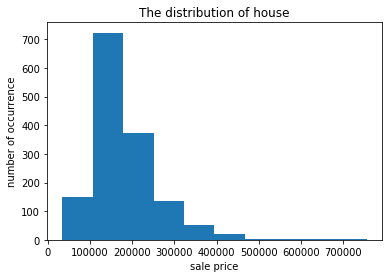

In [440]:
#plottinf figure
plt.hist(houses_c.saleprice)
plt.title("The distribution of house")
plt.xlabel("sale price")
plt.ylabel("number of occurrence")
plt.show()

OBS:
- skewed little to the right, more people are paying lesser than higher amount, and it could be because of place, type, and features.

Before looking at correlation let me bring saleprice to the first.

In [441]:
houses_c = houses_c[['saleprice','id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 
                     'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 
                     'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 
                     'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle', 
                     'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea', 
                     'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 
                     'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2', 
                     'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 
                     'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 
                     'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
                     'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 
                     'functional', 'fireplaces', 'garagetype', 'garageyrblt', 'garagefinish', 
                     'garagecars', 'garagearea', 'garagequal', 'garagecond', 'paveddrive', 
                     'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 
                     'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saletype', 
                     'salecondition']]

### Correlation Matrix:

In [442]:
houses_c.corr()

,saleprice,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,...,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
saleprice,1.000000,-0.021917,-0.084284,0.334901,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,...,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923
id,-0.021917,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,...,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712
mssubclass,-0.084284,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,...,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407
lotfrontage,0.334901,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179700,...,0.323663,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768
lotarea,0.263843,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,...,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261
overallqual,0.790982,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
overallcond,-0.077856,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,...,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950
yearbuilt,0.522897,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618
yearremodadd,0.507101,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,...,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743
masvnrarea,0.477493,-0.050298,0.022936,0.179700,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,...,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201


OBS:
- saleprice is highly correlated to **overallqual, totalbsmtsf, firstflrsf, grlivarea, garagecars, garagearea**, So saleprice is highly depended on overall quality of house, total basement squarefoot, first floor square feet, ground living area sq feet, garage's cara capacity, garage's area in sq ft. Saleprice is also depended on other features but not highly, but may be if some features added together gives high correlation to saleprice.	

### Visualization of  correlation using sns:

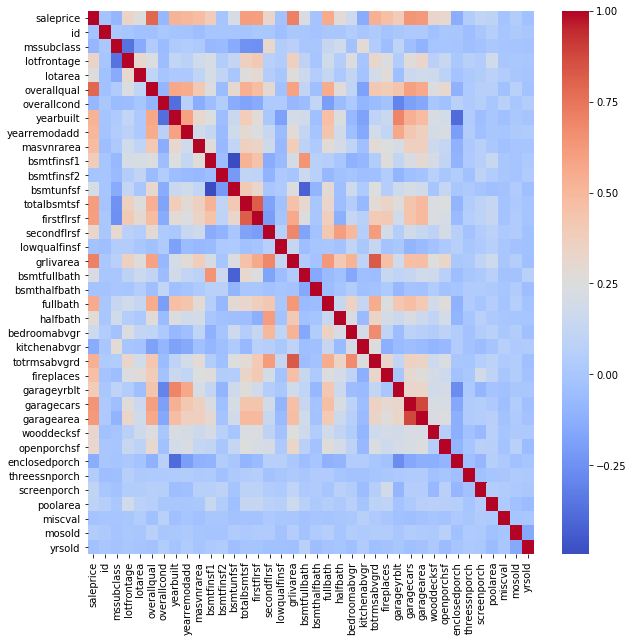

In [443]:
#plotting sns figure for correlation
plt.figure(figsize=(10,10))
sns.heatmap(houses_c.corr(),cmap='coolwarm')

#### OBS:
- sale price looks highly correlated to overallqual, yearbuilt, yearrremodadd, masvnarea, bsmtfinsf1, totalbsmtsf, firstflrsf, grlivarea, fullbath, totrmsabvgrd, fireplaces, garageyrblt, garagecars, garagearea.
- overallqual is correlated to yearbuilt, yearrremodadd, totalbsmtsf, firstflrsf, grlivarea, fullbath, garagecars, garagearea.
- masvnarea, fireplaces are not highly correlated to other features.
- Could use Overallqual, masvnarea, and fireplaces for modelling.

### Visualization of relation of each features to saleprice:
Visualization of comparison is breaked into several for good visualization:

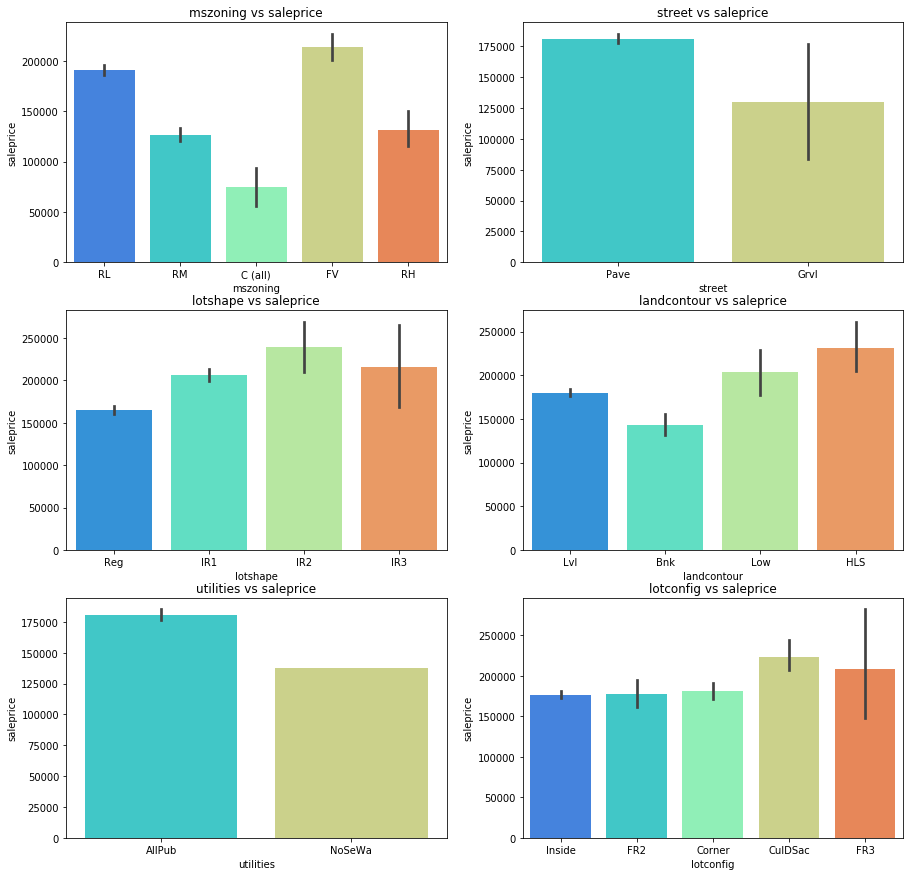

In [444]:
#finding ground relation of each features to target using histogram
#plotting figure 
plt.figure(figsize=(15,15))

#subplts for visualization
plt.subplot(3,2,1)
sns.barplot(houses_c['mszoning'], houses_c['saleprice'], palette='rainbow')
plt.title("mszoning vs saleprice")

plt.subplot(3,2,2)
sns.barplot(houses_c['street'], houses_c['saleprice'], palette='rainbow')
plt.title("street vs saleprice")


plt.subplot(3,2,3)
sns.barplot(houses_c['lotshape'], houses_c['saleprice'], palette='rainbow')
plt.title("lotshape vs saleprice")


plt.subplot(3,2,4)
sns.barplot(houses_c['landcontour'], houses_c['saleprice'], palette='rainbow')
plt.title("landcontour vs saleprice")


plt.subplot(3,2,5)
sns.barplot(houses_c['utilities'], houses_c['saleprice'], palette='rainbow')
plt.title("utilities vs saleprice")

plt.subplot(3,2,6)
sns.barplot(houses_c['lotconfig'], houses_c['saleprice'], palette='rainbow')
plt.title("lotconfig vs saleprice")


plt.show()


#### OBS:
- Mszoning: higher saleprice for floating Village Residential, and then Residential low density, and commercial has lowest saleprice than others.
- Street: Paved one has higher sale price than grvl.
- Lotshape: IR2 moderatly irreguar has higher saleprice, regualr lotshape has lowest saleprice than others.
- Landcontour: HLS hills one has higher saleprice, and Banked one got lowest saleprice.
- Utilities: AllPub has higher saleprice and NoSeWa got the lowest sale price.
- Lotconfig: CulDSac has higher saleprice and Inside one got the lowest saleprice.

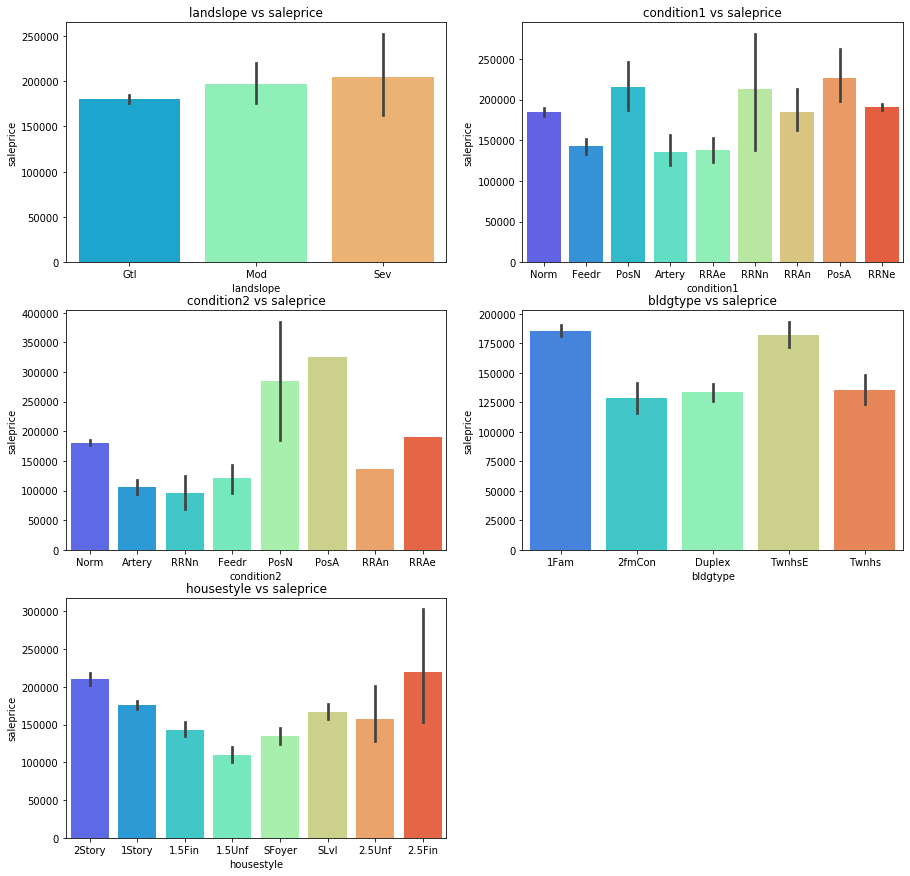

In [445]:
#plotting figure 
plt.figure(figsize=(15, 15))

#subplts for visualization
plt.subplot(3, 2, 1)
sns.barplot(houses_c['landslope'], houses_c['saleprice'], palette='rainbow')
plt.title("landslope vs saleprice")

plt.subplot(3, 2,2)
sns.barplot(houses_c['condition1'], houses_c['saleprice'], palette='rainbow')
plt.title("condition1 vs saleprice")

plt.subplot(3,2,3)
sns.barplot(houses_c['condition2'], houses_c['saleprice'], palette='rainbow')
plt.title("condition2 vs saleprice")


plt.subplot(3,2,4)
sns.barplot(houses_c['bldgtype'], houses_c['saleprice'], palette='rainbow')
plt.title("bldgtype vs saleprice")

plt.subplot(3,2,5)
sns.barplot(houses_c['housestyle'], houses_c['saleprice'], palette='rainbow')
plt.title("housestyle vs saleprice")

plt.show()

#### OBS:

- lanslope: Sev has higher sale proce than Mod and gtl
- Condition 1: PosA is highest, and then PosN, and then RRNn and lowest sale price is for Artery.
- Condition 2: Lowest is Artery and Highest is PosA
- Bldgtype: Highest sale price for 1Fam, and then TwnhsE, lowest is for 2fmCon
- housestyle: Highest for 2.5Fin, and then 2Story, lowest for 1.5Unf

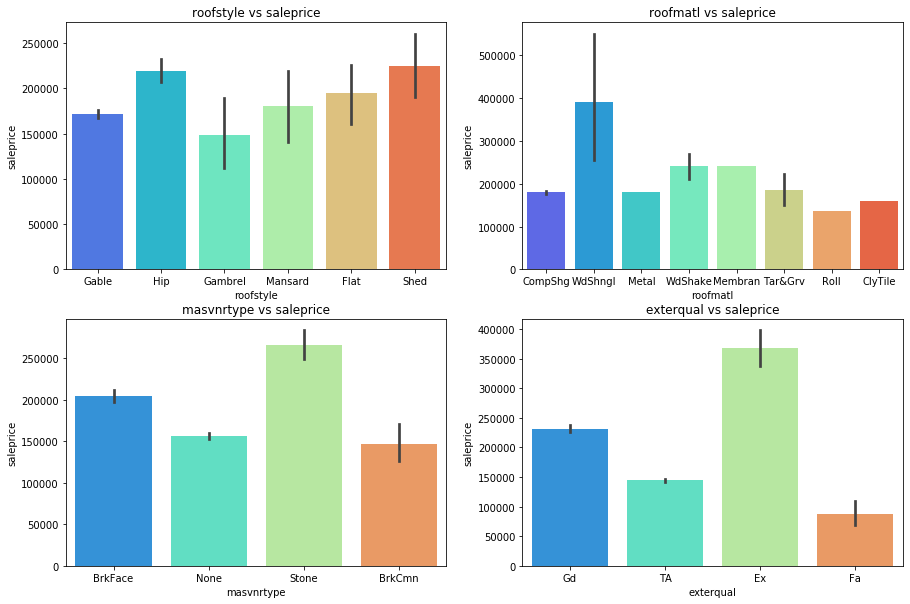

In [446]:
#plotting figure 
plt.figure(figsize=(15, 10))

#subplts for visualization
plt.subplot(2,2,1)
sns.barplot(houses_c['roofstyle'], houses_c['saleprice'], palette='rainbow')
plt.title("roofstyle vs saleprice")


plt.subplot(2,2,2)
sns.barplot(houses_c['roofmatl'], houses_c['saleprice'], palette='rainbow')
plt.title("roofmatl vs saleprice")

plt.subplot(2,2,3)
sns.barplot(houses_c['masvnrtype'], houses_c['saleprice'], palette='rainbow')
plt.title("masvnrtype vs saleprice")

plt.subplot(2,2,4)
sns.barplot(houses_c['exterqual'], houses_c['saleprice'], palette='rainbow')
plt.title("exterqual vs saleprice")

plt.show()

#### OBS:
- roofstyle: Highest for Shed and then Hip, lowest for Gambrel
- roofmatl: Highest for WdShngl, and lowest for Roll
- masvnrtype: Highest for Stone and lowest for BrkCmn
- exterqual: Highest for Ex, and lowest for Fa

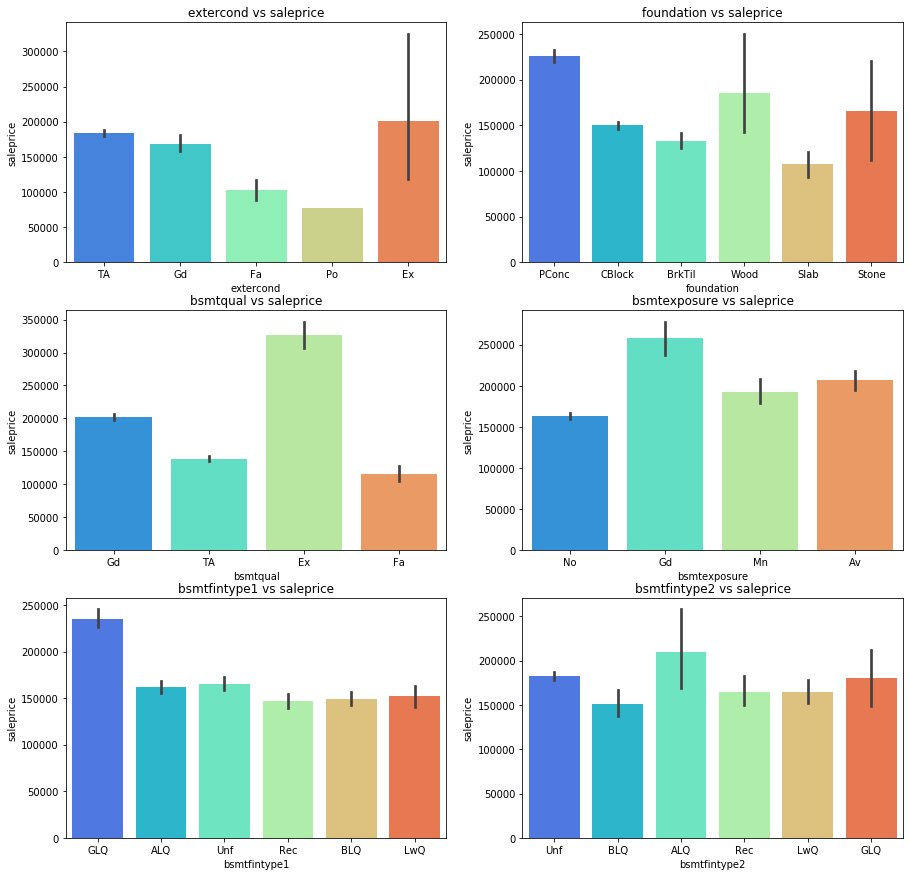

In [447]:
#plotting figure 
plt.figure(figsize=(15, 15))

#subplts for visualization
plt.subplot(3,2,1)
sns.barplot(houses_c['extercond'], houses_c['saleprice'], palette='rainbow')
plt.title("extercond vs saleprice")

plt.subplot(3,2,2)
sns.barplot(houses_c['foundation'], houses_c['saleprice'], palette='rainbow')
plt.title("foundation vs saleprice")

plt.subplot(3,2,3)
sns.barplot(houses_c['bsmtqual'], houses_c['saleprice'], palette='rainbow')
plt.title("bsmtqual vs saleprice")

plt.subplot(3,2,4)
sns.barplot(houses_c['bsmtexposure'], houses_c['saleprice'], palette='rainbow')
plt.title("bsmtexposure vs saleprice")

plt.subplot(3,2,5)
sns.barplot(houses_c['bsmtfintype1'], houses_c['saleprice'], palette='rainbow')
plt.title("bsmtfintype1 vs saleprice")

plt.subplot(3,2,6)
sns.barplot(houses_c['bsmtfintype2'], houses_c['saleprice'], palette='rainbow')
plt.title("bsmtfintype2 vs saleprice")

plt.show()

#### OBS:
- extercond: Highest for Ex, and Lowest for Po
- foundation: Highest for PConc and lowest Slab
- bsmtqual: Highest for Ex and lowest for Fa
- bsmtexposure: Highest for Gd and lowest for No
- bsmtfintype1: Highest for GLQ, and lowest for Rec
- bsmtfintype2: Highest for ALQ and lowest for BLQ

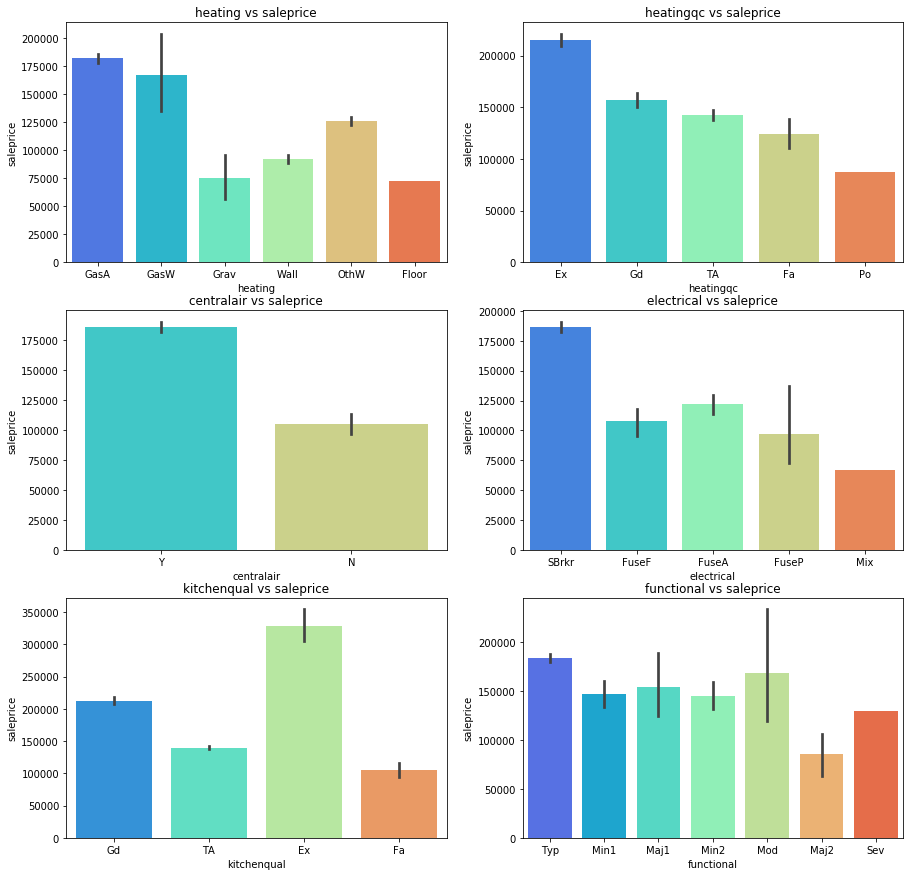

In [448]:
#plotting figure 
plt.figure(figsize=(15, 15))

#subplts for visualization
plt.subplot(3,2,1)
sns.barplot(houses_c['heating'], houses_c['saleprice'], palette='rainbow')
plt.title("heating vs saleprice")

plt.subplot(3,2,2)
sns.barplot(houses_c['heatingqc'], houses_c['saleprice'], palette='rainbow')
plt.title("heatingqc vs saleprice")

plt.subplot(3,2,3)
sns.barplot(houses_c['centralair'], houses_c['saleprice'], palette='rainbow')
plt.title("centralair vs saleprice")

plt.subplot(3,2,4)
sns.barplot(houses_c['electrical'], houses_c['saleprice'], palette='rainbow')
plt.title("electrical vs saleprice")

plt.subplot(3,2,5)
sns.barplot(houses_c['kitchenqual'], houses_c['saleprice'], palette='rainbow')
plt.title("kitchenqual vs saleprice")


plt.subplot(3,2,6)
sns.barplot(houses_c['functional'], houses_c['saleprice'], palette='rainbow')
plt.title("functional vs saleprice")

plt.show()

#### OBS:
- heating: Highest for GasA, and then GasW, lowest for GasV
- heatingqc: Highest for Ex, and lowest for Po
- centralair: with CA got higher sale price than without
- electrical: Highest for SBrkr and lowest for Mix
- kitchenqual: Highest for Ex and lowest for Fa, there is no Po
- functional: Highest for Typ, and then Mod, and lowest for Maj2

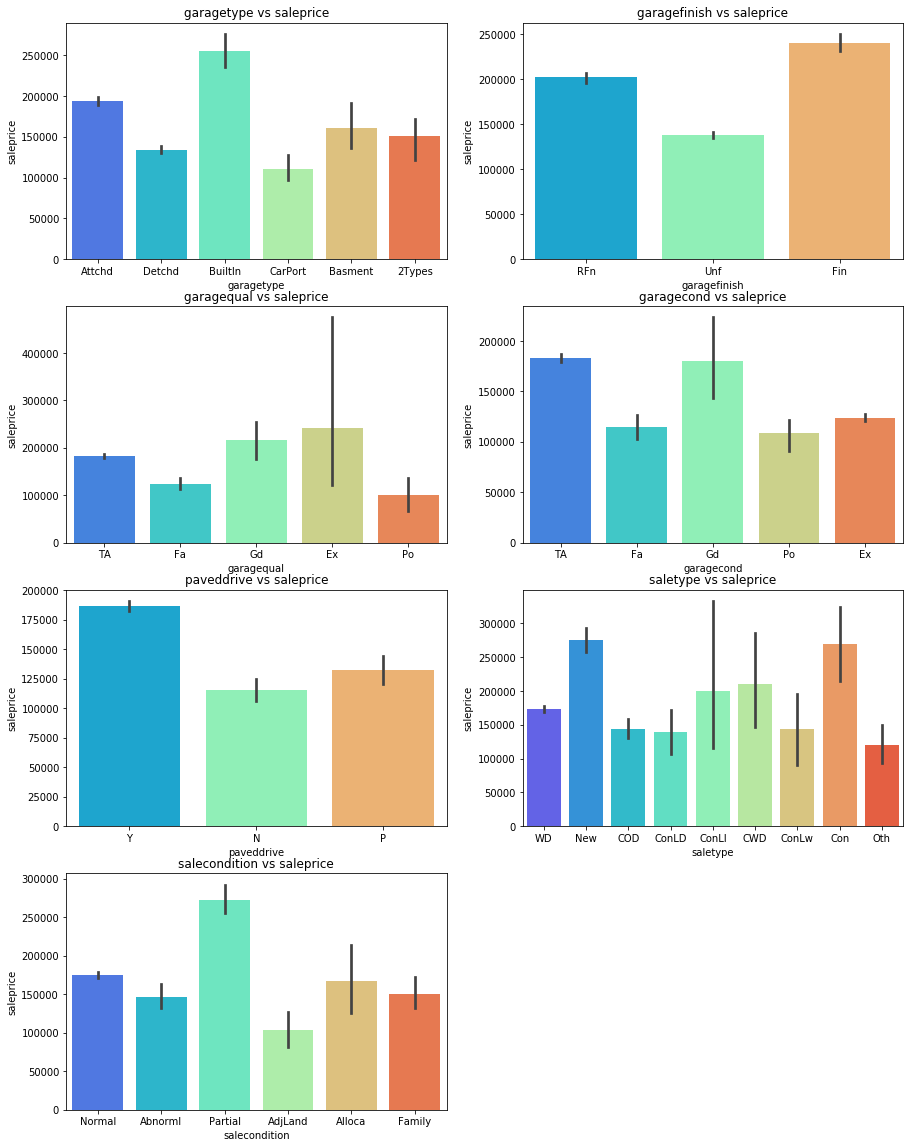

In [449]:
#plotting figure 
plt.figure(figsize=(15, 20))

#subplts for visualization
plt.subplot(4,2,1)
sns.barplot(houses_c['garagetype'], houses_c['saleprice'], palette='rainbow')
plt.title("garagetype vs saleprice")

plt.subplot(4,2,2)
sns.barplot(houses_c['garagefinish'], houses_c['saleprice'], palette='rainbow')
plt.title("garagefinish vs saleprice")

plt.subplot(4,2,3)
sns.barplot(houses_c['garagequal'], houses_c['saleprice'], palette='rainbow')
plt.title("garagequal vs saleprice")

plt.subplot(4,2,4)
sns.barplot(houses_c['garagecond'], houses_c['saleprice'], palette='rainbow')
plt.title("garagecond vs saleprice")

plt.subplot(4,2,5)
sns.barplot(houses_c['paveddrive'], houses_c['saleprice'], palette='rainbow')
plt.title("paveddrive vs saleprice")

plt.subplot(4,2,6)
sns.barplot(houses_c['saletype'], houses_c['saleprice'], palette='rainbow')
plt.title("saletype vs saleprice")

plt.subplot(4,2,7)
sns.barplot(houses_c['salecondition'], houses_c['saleprice'], palette='rainbow')
plt.title("salecondition vs saleprice")

plt.show()


#### OBS:
- garagetype: Highest for Builtin and lowest for CarPort
- garagefinish:  Highest for fin an dlowest for Unfin
- garagequal:  Highest for Ex, and lowest for Po
- garagecond:  Highest for TA and lowest for Po
- pavedrive:  Highest for with paved drive and then partial one and lowest without pave drive
- saletype:  Highest for New and lowest for Con
- salecondition:  Highest for Partial and lowest for AdjLand

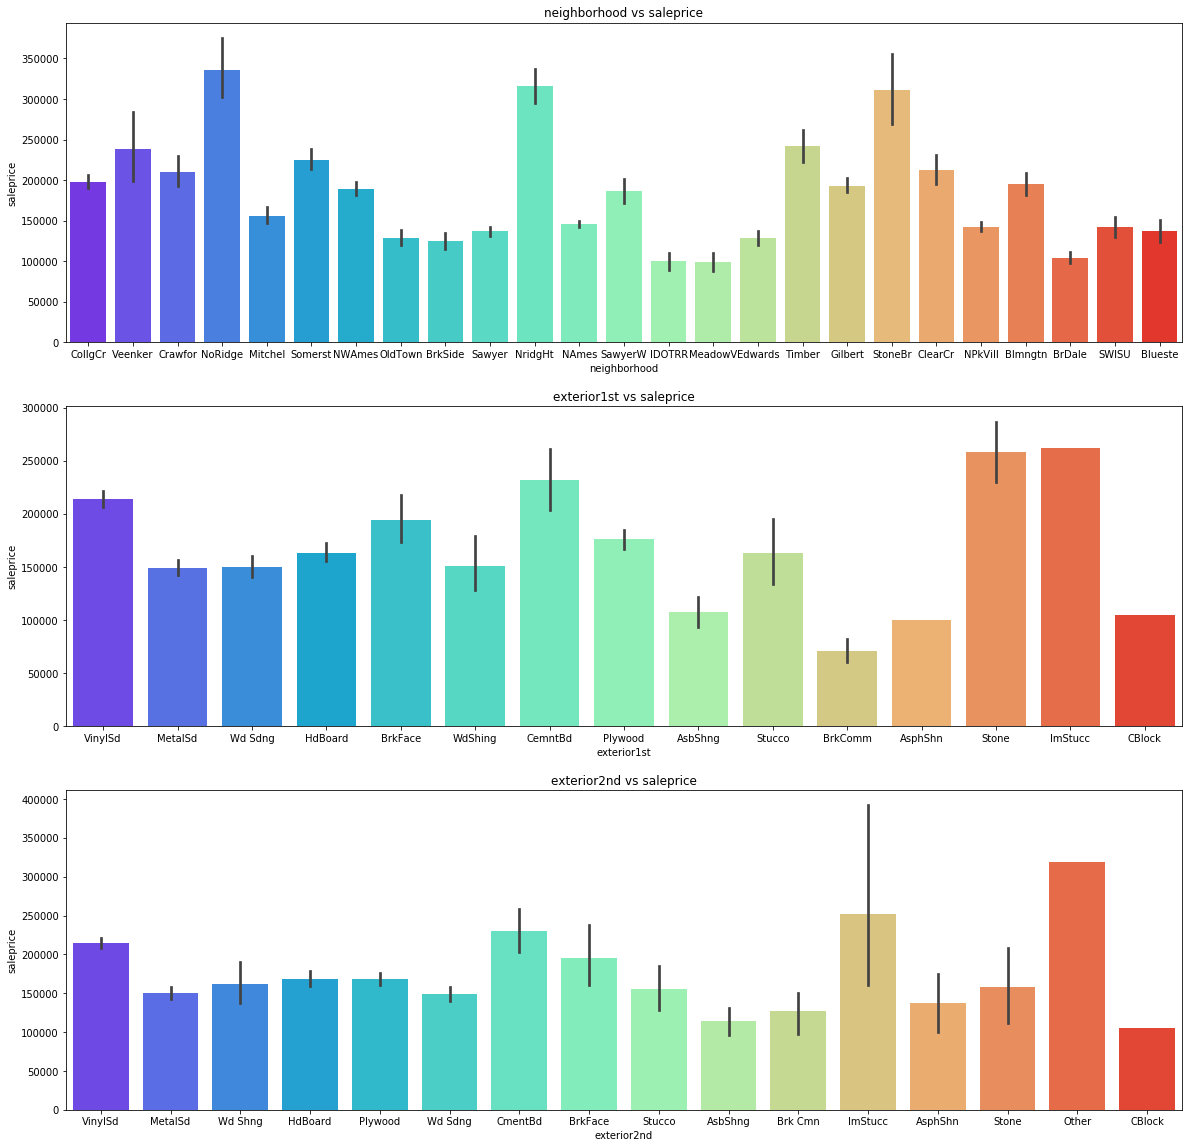

In [450]:
#plotting visualization for neighbourhood, exterior1st and 2nd for clear vision
plt.figure(figsize=(20,20))

plt.subplot(3,1,1)
sns.barplot(houses_c['neighborhood'], houses_c['saleprice'], palette='rainbow')
plt.title("neighborhood vs saleprice")

plt.subplot(3,1,2)
sns.barplot(houses_c['exterior1st'], houses_c['saleprice'], palette='rainbow')
plt.title("exterior1st vs saleprice")

plt.subplot(3,1,3)
sns.barplot(houses_c['exterior2nd'], houses_c['saleprice'], palette='rainbow')
plt.title("exterior2nd vs saleprice")

plt.show()


OBS:

- NoRidge got higher saleprice, whereas Meadow got the lowest saleprice among the neighbourhood.

- ImStucc(Imitation Stucco) got higher saleprice, whereas, BrkComm(Brick common) got the lowest saleprice for the 1st exterior covering material.

- Other got higher saleprice and then ImStucc(Imitation Stucco), and  AsbShng( Asbestos Shingles) got the lowest saleprice for the 2nd exterior covering material.

#### Scatter  and Barplot plot to see visualization of numerical features:

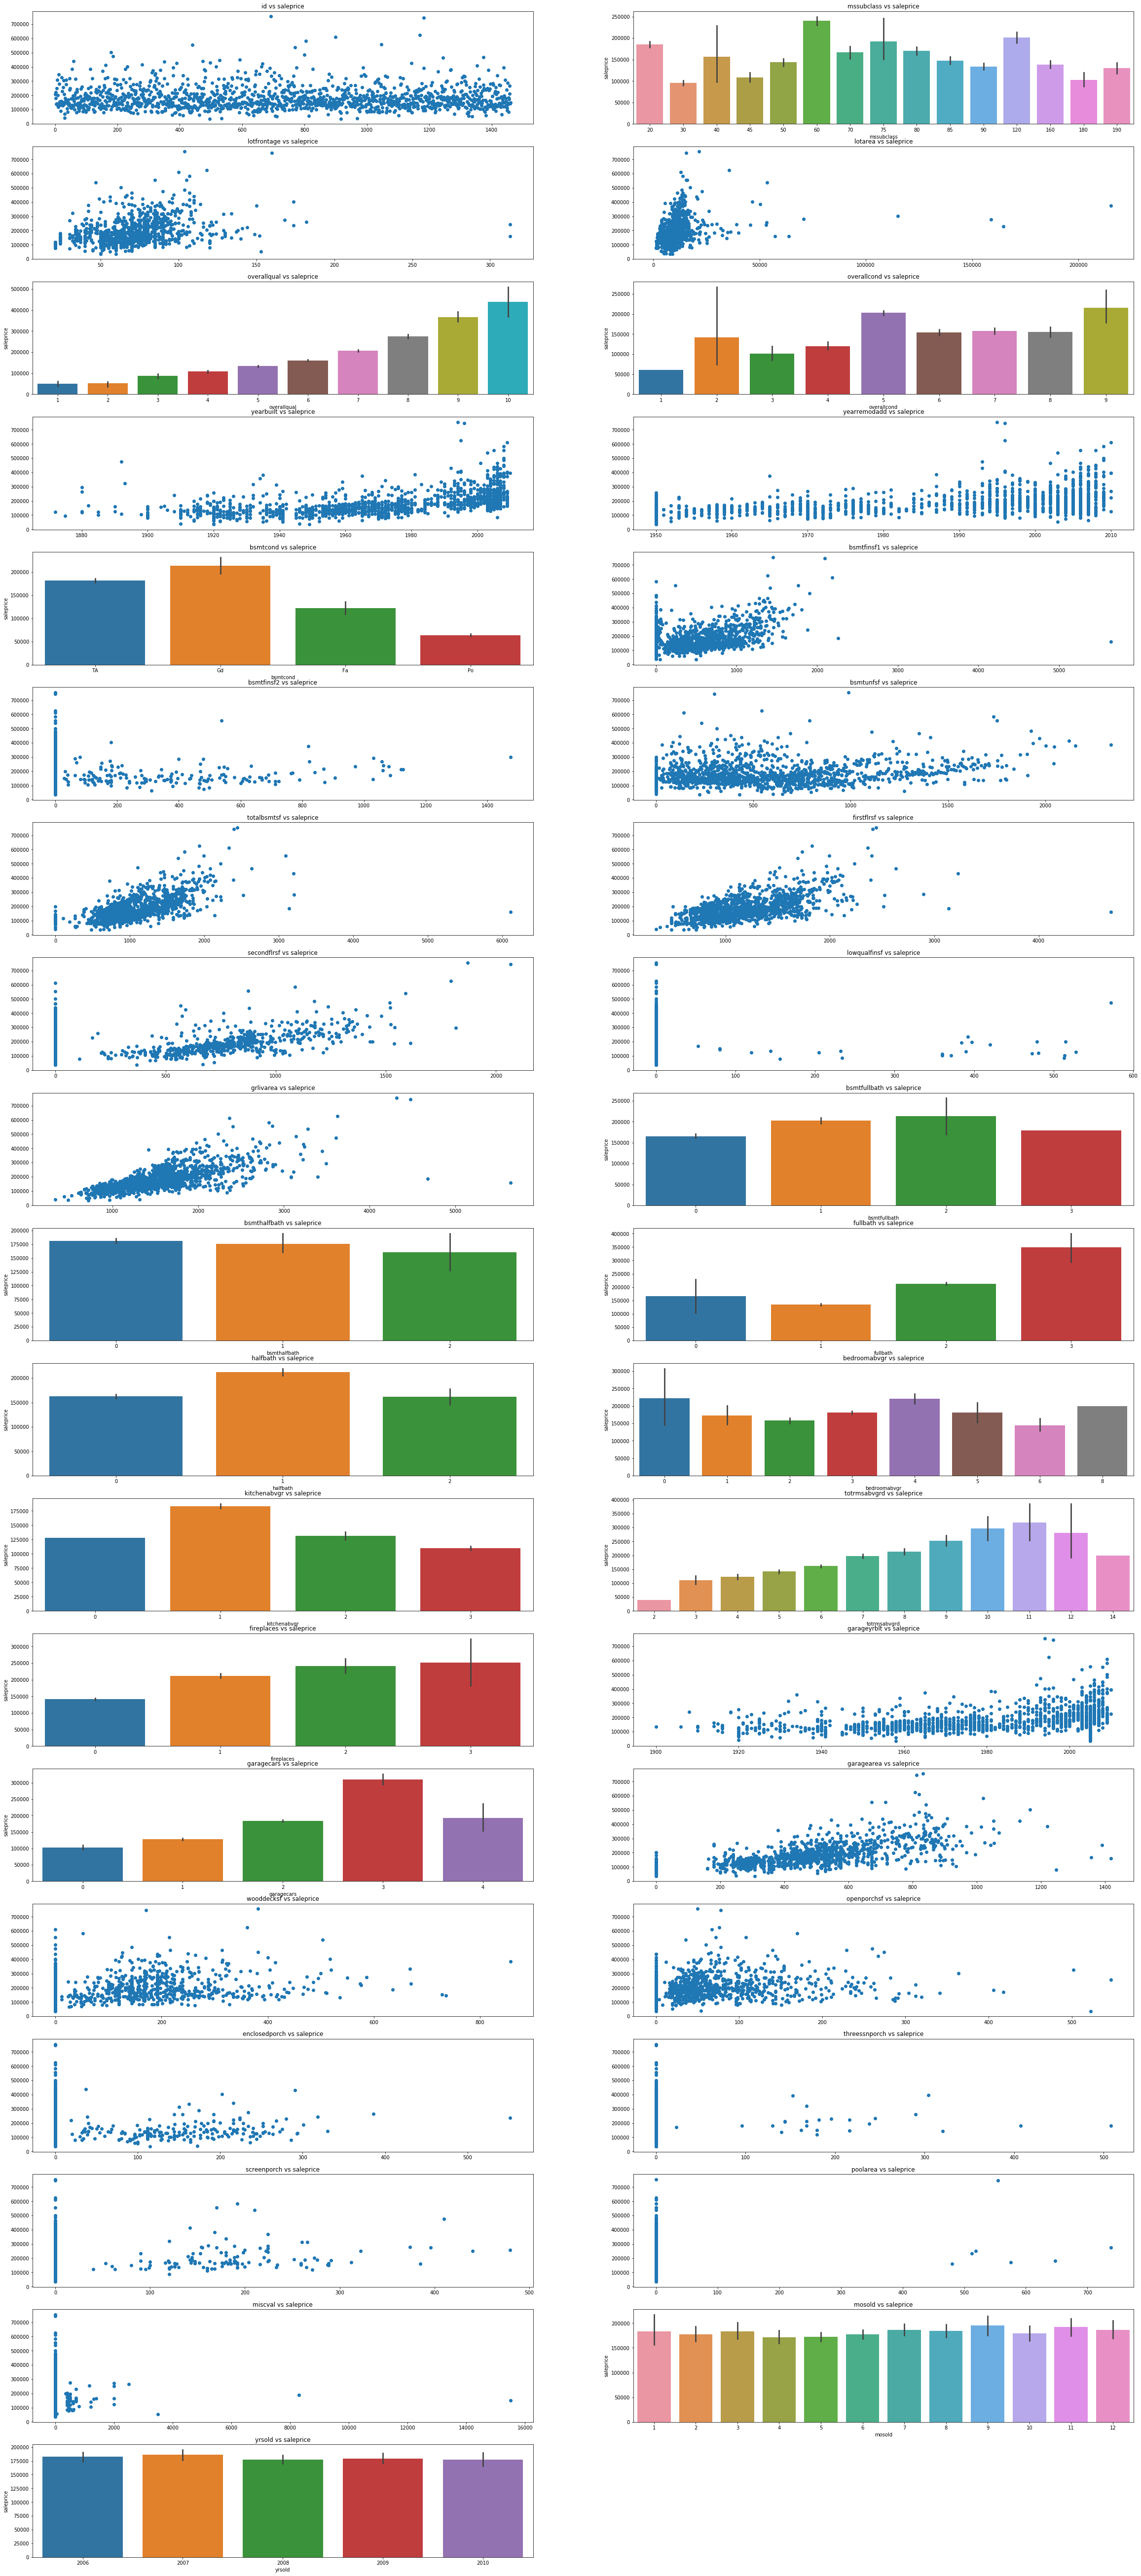

In [451]:
#finding ground relation of each features to target using scatter plot

plt.figure(figsize=(40,100))

plt.subplot(20,2,1)
plt.scatter(houses_c["id"], houses_c["saleprice"])
plt.title("id vs saleprice")


plt.subplot(20,2,2)
sns.barplot(houses_c["mssubclass"], houses_c["saleprice"])
plt.title("mssubclass vs saleprice")

plt.subplot(20,2,3)
plt.scatter(houses_c["lotfrontage"], houses_c["saleprice"])
plt.title("lotfrontage vs saleprice")


plt.subplot(20,2,4)
plt.scatter(houses_c["lotarea"], houses_c["saleprice"])
plt.title("lotarea vs saleprice")

plt.subplot(20,2,5)
sns.barplot(houses_c["overallqual"], houses_c["saleprice"])
plt.title("overallqual vs saleprice")

plt.subplot(20,2,6)
sns.barplot(houses_c["overallcond"], houses_c["saleprice"])
plt.title("overallcond vs saleprice")

plt.subplot(20,2,7)
plt.scatter(houses_c["yearbuilt"], houses_c["saleprice"])
plt.title("yearbuilt vs saleprice")


plt.subplot(20,2,8)
plt.scatter(houses_c["yearremodadd"], houses_c["saleprice"])
plt.title("yearremodadd vs saleprice")


plt.subplot(20,2,9)
sns.barplot(houses_c["bsmtcond"], houses_c["saleprice"])
plt.title("bsmtcond vs saleprice")

plt.subplot(20,2,10)
plt.scatter(houses_c["bsmtfinsf1"], houses_c["saleprice"])
plt.title("bsmtfinsf1 vs saleprice")


plt.subplot(20,2,11)
plt.scatter(houses_c["bsmtfinsf2"], houses_c["saleprice"])
plt.title("bsmtfinsf2 vs saleprice")

plt.subplot(20,2,12)
plt.scatter(houses_c["bsmtunfsf"], houses_c["saleprice"])
plt.title("bsmtunfsf vs saleprice")

plt.subplot(20,2,13)
plt.scatter(houses_c["totalbsmtsf"], houses_c["saleprice"])
plt.title("totalbsmtsf vs saleprice")

plt.subplot(20,2,14)
plt.scatter(houses_c["firstflrsf"], houses_c["saleprice"])
plt.title("firstflrsf vs saleprice")


plt.subplot(20,2,15)
plt.scatter(houses_c["secondflrsf"], houses_c["saleprice"])
plt.title("secondflrsf vs saleprice")

plt.subplot(20,2,16)
plt.scatter(houses_c["lowqualfinsf"], houses_c["saleprice"])
plt.title("lowqualfinsf vs saleprice")

plt.subplot(20,2,17)
plt.scatter(houses_c["grlivarea"], houses_c["saleprice"])
plt.title("grlivarea vs saleprice")

plt.subplot(20,2,18)
sns.barplot(houses_c["bsmtfullbath"], houses_c["saleprice"])
plt.title("bsmtfullbath vs saleprice")

plt.subplot(20,2,19)
sns.barplot(houses_c["bsmthalfbath"], houses_c["saleprice"])
plt.title("bsmthalfbath vs saleprice")

plt.subplot(20,2,20)
sns.barplot(houses_c["fullbath"], houses_c["saleprice"])
plt.title("fullbath vs saleprice")

plt.subplot(20,2,21)
sns.barplot(houses_c["halfbath"], houses_c["saleprice"])
plt.title("halfbath vs saleprice")

plt.subplot(20,2,22)
sns.barplot(houses_c["bedroomabvgr"], houses_c["saleprice"])
plt.title("bedroomabvgr vs saleprice")

plt.subplot(20,2,23)
sns.barplot(houses_c["kitchenabvgr"], houses_c["saleprice"])
plt.title("kitchenabvgr vs saleprice")

plt.subplot(20,2,24)
sns.barplot(houses_c["totrmsabvgrd"], houses_c["saleprice"])
plt.title("totrmsabvgrd vs saleprice")

plt.subplot(20,2,25)
sns.barplot(houses_c["fireplaces"], houses_c["saleprice"])
plt.title("fireplaces vs saleprice")

plt.subplot(20,2,26)
plt.scatter(houses_c["garageyrblt"], houses_c["saleprice"])
plt.title("garageyrblt vs saleprice")

plt.subplot(20,2,27)
sns.barplot(houses_c["garagecars"], houses_c["saleprice"])
plt.title("garagecars vs saleprice")

plt.subplot(20,2,28)
plt.scatter(houses_c["garagearea"], houses_c["saleprice"])
plt.title("garagearea vs saleprice")

plt.subplot(20,2,29)
plt.scatter(houses_c["wooddecksf"], houses_c["saleprice"])
plt.title("wooddecksf vs saleprice")


plt.subplot(20,2,30)
plt.scatter(houses_c["openporchsf"], houses_c["saleprice"])
plt.title("openporchsf vs saleprice")

plt.subplot(20,2,31)
plt.scatter(houses_c["enclosedporch"], houses_c["saleprice"])
plt.title("enclosedporch vs saleprice")

plt.subplot(20,2,32)
plt.scatter(houses_c["threessnporch"], houses_c["saleprice"])
plt.title("threessnporch vs saleprice")

plt.subplot(20,2,33)
plt.scatter(houses_c["screenporch"], houses_c["saleprice"])
plt.title("screenporch vs saleprice")

plt.subplot(20,2,34)
plt.scatter(houses_c["poolarea"], houses_c["saleprice"])
plt.title("poolarea vs saleprice")

plt.subplot(20,2,35)
plt.scatter(houses_c["miscval"], houses_c["saleprice"])
plt.title("miscval vs saleprice")

plt.subplot(20,2,36)
sns.barplot(houses_c["mosold"], houses_c["saleprice"])
plt.title("mosold vs saleprice")

plt.subplot(20,2,37)
sns.barplot(houses_c["yrsold"], houses_c["saleprice"])
plt.title("yrsold vs saleprice")

plt.show()


OBS:
- I don't see any correlation between id and saleprice.
- Good correlation of sale price to mssubclass 60.
- Have correlation of lotfrontage, lotarea, overallcond of 9, yearbuilt, yearremodadd, Gd bsmtcond,bsmtunfsf, bsmtfinsf2
- Highly correlated to overallqual, bsmtfinsf1, totalbsmtsf, firstflrsf, secondflrsf, grlivarea as it is increasing with increasing saleprice.
- lowqualfinsf doesn't show much correlation which makes sense, yrsold doesn't matter from above relation, september looks expensive than other time of year.

### Feature Engineering:

#### one hot-coding, through dummies.

In [452]:
houses_c["is_Pave"] = pd.get_dummies(houses.street, drop_first=True)
houses_c["is_AllPub"] = pd.get_dummies(houses.utilities, drop_first=True)
houses_c["Y"] = pd.get_dummies(houses.centralair, drop_first=True)


In [453]:
dummy = pd.get_dummies(houses_c[['mszoning', 'lotshape', 'landcontour', 'lotconfig', 'landslope',
              'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 
              'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 
              'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'electrical',
              'kitchenqual', 'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
              'paveddrive', 'saletype', 'salecondition']])
dummy.head()

,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_Bnk,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [454]:
houses_c = pd.concat([houses_c, dummy], axis=1)
houses_c.head()

,saleprice,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,208500,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
1,181500,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
2,223500,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0
3,140000,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,...,0,0,0,1,1,0,0,0,0,0
4,250000,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,0,1,0


### Feature Selection:

#### Correlation matrix:
checking for correlation of all the features

Separating features in different file to make it easier to see the correlation of all features:

In [455]:
houses_c1 = houses_c[['saleprice', 'id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street', 
                      'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 
                      'condition1', 'condition2', 'bldgtype', 'housestyle', 'overallqual', 'overallcond', 
                      'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 
                      'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation']]
houses_c2 = houses_c[['saleprice', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 
                      'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 
                      'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 
                      'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
                      'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces', 'garagetype', 'garageyrblt', 
                      'garagefinish']]
houses_c3 = houses_c[['saleprice', 'garagecars', 'garagearea', 'garagequal', 'garagecond', 'paveddrive', 
                      'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 
                      'miscval', 'mosold', 'yrsold', 'saletype', 'salecondition', 'is_Pave', 'is_AllPub', 'Y', 
                      'mszoning_C (all)', 'mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'lotshape_IR1', 
                      'lotshape_IR2', 'lotshape_IR3', 'lotshape_Reg', 'landcontour_Bnk']]
houses_c4 = houses_c[['saleprice', 'landcontour_HLS', 'landcontour_Low', 'landcontour_Lvl', 'lotconfig_Corner', 
                      'lotconfig_CulDSac', 'lotconfig_FR2', 'lotconfig_FR3', 'lotconfig_Inside', 'landslope_Gtl', 
                      'landslope_Mod', 
                      'landslope_Sev', 'neighborhood_Blmngtn', 'neighborhood_Blueste', 'neighborhood_BrDale', 
                      'neighborhood_BrkSide', 'neighborhood_ClearCr', 'neighborhood_CollgCr', 'neighborhood_Crawfor', 
                      'neighborhood_Edwards', 'neighborhood_Gilbert', 'neighborhood_IDOTRR', 'neighborhood_MeadowV',
                      'neighborhood_Mitchel', 'neighborhood_NAmes', 'neighborhood_NPkVill', 'neighborhood_NWAmes', 
                      'neighborhood_NoRidge', 'neighborhood_NridgHt', 'neighborhood_OldTown']]

In [456]:
houses_c5 = houses_c[['saleprice', 'neighborhood_SWISU', 'neighborhood_Sawyer', 'neighborhood_SawyerW', 
                      'neighborhood_Somerst', 'neighborhood_StoneBr', 'neighborhood_Timber', 
                      'neighborhood_Veenker', 'condition1_Artery', 'condition1_Feedr', 'condition1_Norm', 
                      'condition1_PosA', 'condition1_PosN', 'condition1_RRAe', 'condition1_RRAn', 'condition1_RRNe', 
                      'condition1_RRNn', 'condition2_Artery', 'condition2_Feedr', 'condition2_Norm', 
                      'condition2_PosA', 'condition2_PosN', 'condition2_RRAe', 'condition2_RRAn', 'condition2_RRNn', 
                      'bldgtype_1Fam', 'bldgtype_2fmCon', 'bldgtype_Duplex', 'bldgtype_Twnhs', 'bldgtype_TwnhsE']]
houses_c6 = houses_c[['saleprice', 'housestyle_1.5Fin', 'housestyle_1.5Unf', 'housestyle_1Story', 
                      'housestyle_2.5Fin', 'housestyle_2.5Unf', 'housestyle_2Story', 'housestyle_SFoyer', 
                      'housestyle_SLvl', 'roofstyle_Flat', 'roofstyle_Gable', 'roofstyle_Gambrel', 'roofstyle_Hip', 
                      'roofstyle_Mansard', 'roofstyle_Shed', 'roofmatl_ClyTile', 'roofmatl_CompShg', 
                      'roofmatl_Membran', 'roofmatl_Metal', 'roofmatl_Roll', 'roofmatl_Tar&Grv', 'roofmatl_WdShake', 
                      'roofmatl_WdShngl', 'exterior1st_AsbShng', 'exterior1st_AsphShn', 'exterior1st_BrkComm', 
                      'exterior1st_BrkFace', 'exterior1st_CBlock', 'exterior1st_CemntBd', 'exterior1st_HdBoard']]
houses_c7 = houses_c[['saleprice', 'exterior1st_ImStucc', 'exterior1st_MetalSd', 'exterior1st_Plywood', 
                      'exterior1st_Stone', 'exterior1st_Stucco', 'exterior1st_VinylSd', 'exterior1st_Wd Sdng', 
                      'exterior1st_WdShing', 'exterior2nd_AsbShng', 'exterior2nd_AsphShn', 'exterior2nd_Brk Cmn', 
                      'exterior2nd_BrkFace', 'exterior2nd_CBlock', 'exterior2nd_CmentBd', 'exterior2nd_HdBoard', 
                      'exterior2nd_ImStucc', 'exterior2nd_MetalSd', 'exterior2nd_Other', 'exterior2nd_Plywood', 
                      'exterior2nd_Stone', 'exterior2nd_Stucco', 'exterior2nd_VinylSd', 'exterior2nd_Wd Sdng', 
                      'exterior2nd_Wd Shng', 'masvnrtype_BrkCmn', 'masvnrtype_BrkFace', 'masvnrtype_None', 
                      'masvnrtype_Stone', 'exterqual_Ex']]
houses_c8 = houses_c[['saleprice', 'exterqual_Fa', 'exterqual_Gd', 'exterqual_TA', 'extercond_Ex', 'extercond_Fa', 
                      'extercond_Gd', 'extercond_Po', 'extercond_TA', 'foundation_BrkTil', 'foundation_CBlock', 
                      'foundation_PConc', 'foundation_Slab', 'foundation_Stone', 'foundation_Wood', 'bsmtqual_Ex', 
                      'bsmtqual_Fa', 'bsmtqual_Gd', 'bsmtqual_TA', 'bsmtexposure_Av', 'bsmtexposure_Gd', 
                      'bsmtexposure_Mn', 'bsmtexposure_No', 'bsmtfintype1_ALQ', 'bsmtfintype1_BLQ', 
                      'bsmtfintype1_GLQ', 'bsmtfintype1_LwQ', 'bsmtfintype1_Rec', 'bsmtfintype1_Unf', 
                      'bsmtfintype2_ALQ']]


In [457]:
houses_c9 = houses_c[['saleprice', 'bsmtfintype2_BLQ', 'bsmtfintype2_GLQ', 'bsmtfintype2_LwQ', 
                      'bsmtfintype2_Rec', 'bsmtfintype2_Unf', 'heating_Floor', 'heating_GasA', 
                      'heating_GasW', 'heating_Grav', 'heating_OthW', 'heating_Wall', 'heatingqc_Ex', 
                      'heatingqc_Fa', 'heatingqc_Gd', 'heatingqc_Po', 'heatingqc_TA', 'electrical_FuseA', 
                      'electrical_FuseF', 'electrical_FuseP', 'electrical_Mix', 'electrical_SBrkr', 
                      'kitchenqual_Ex', 'kitchenqual_Fa', 'kitchenqual_Gd', 'kitchenqual_TA', 'functional_Maj1', 
                      'functional_Maj2', 'functional_Min1', 'functional_Min2']]
houses_c10 = houses_c[['saleprice', 'functional_Mod', 'functional_Sev', 'functional_Typ', 'garagetype_2Types', 
                       'garagetype_Attchd', 'garagetype_Basment', 'garagetype_BuiltIn', 'garagetype_CarPort', 
                       'garagetype_Detchd', 'garagefinish_Fin', 'garagefinish_RFn', 'garagefinish_Unf', 
                       'garagequal_Ex', 'garagequal_Fa', 'garagequal_Gd', 'garagequal_Po', 'garagequal_TA', 
                       'garagecond_Ex', 'garagecond_Fa', 'garagecond_Gd', 'garagecond_Po', 'garagecond_TA', 
                       'paveddrive_N', 'paveddrive_P', 'paveddrive_Y', 'saletype_COD', 'saletype_CWD', 
                       'saletype_Con', 'saletype_ConLD']]
houses_c11 = houses_c[['saleprice', 'saletype_ConLI', 'saletype_ConLw', 'saletype_New', 'saletype_Oth', 
                       'saletype_WD', 'salecondition_Abnorml', 'salecondition_AdjLand', 'salecondition_Alloca', 
                       'salecondition_Family', 'salecondition_Normal', 'salecondition_Partial']]

Correlation:

In [458]:
houses_c1.corr() 

,saleprice,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea
saleprice,1.000000,-0.021917,-0.084284,0.334901,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493
id,-0.021917,1.000000,0.011156,-0.009601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298
mssubclass,-0.084284,0.011156,1.000000,-0.357056,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936
lotfrontage,0.334901,-0.009601,-0.357056,1.000000,0.306795,0.234196,-0.052820,0.117598,0.082746,0.179700
lotarea,0.263843,-0.033226,-0.139781,0.306795,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160
overallqual,0.790982,-0.028365,0.032628,0.234196,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876
overallcond,-0.077856,0.012609,-0.059316,-0.052820,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101
yearbuilt,0.522897,-0.012713,0.027850,0.117598,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707
yearremodadd,0.507101,-0.021998,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618
masvnrarea,0.477493,-0.050298,0.022936,0.179700,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000


OBS:
Correlation greater than 0.5 are:
- overallqual,  yearbuilt, yearremodadd.

In [459]:
houses_c2.corr() 


,saleprice,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt
saleprice,1.000000,0.386420,-0.011378,0.214479,0.613581,0.605852,0.319334,-0.025606,0.708624,0.227122,-0.016844,0.560664,0.284108,0.168213,-0.135907,0.533723,0.466929,0.397778
bsmtfinsf1,0.386420,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.119267
bsmtfinsf2,-0.011378,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.094208
bsmtunfsf,0.214479,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.172350
totalbsmtsf,0.613581,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.262945
firstflrsf,0.605852,0.445863,0.097117,0.317987,0.819530,1.000000,-0.202646,-0.014241,0.566024,0.244671,0.001956,0.380637,-0.119916,0.127401,0.068101,0.409516,0.410531,0.182240
secondflrsf,0.319334,-0.137079,-0.099260,0.004469,-0.174512,-0.202646,1.000000,0.063353,0.687501,-0.169494,-0.023855,0.421378,0.609707,0.502901,0.059306,0.616423,0.194561,0.052291
lowqualfinsf,-0.025606,-0.064503,0.014807,0.028167,-0.033245,-0.014241,0.063353,1.000000,0.134683,-0.047143,-0.005842,-0.000710,-0.027080,0.105607,0.007522,0.131185,-0.021272,0.007298
grlivarea,0.708624,0.208171,-0.009640,0.240257,0.454868,0.566024,0.687501,0.134683,1.000000,0.034836,-0.018918,0.630012,0.415772,0.521270,0.100063,0.825489,0.461679,0.178186
bsmtfullbath,0.227122,0.649212,0.158678,-0.422900,0.307351,0.244671,-0.169494,-0.047143,0.034836,1.000000,-0.147871,-0.064512,-0.030905,-0.150673,-0.041503,-0.053275,0.137928,0.105716


OBS:
Correlation greater than 0.5 are:
- grlivarea, totalbsmtsf, firstflrsf, fullbath, totrmsabvgrd 


In [460]:
houses_c3.corr() 

,saleprice,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,...,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,lotshape_IR1,lotshape_IR2,lotshape_IR3,lotshape_Reg,landcontour_Bnk
saleprice,1.000000,0.640409,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,...,-0.111257,0.089950,-0.065429,0.245063,-0.288065,0.223284,0.126096,0.036720,-0.267672,-0.101124
garagecars,0.640409,1.000000,0.882475,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,...,-0.051927,0.102851,-0.090477,0.175167,-0.221834,0.161090,0.086285,0.037004,-0.193305,-0.109773
garagearea,0.623431,0.882475,1.000000,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,...,-0.016778,0.114859,-0.073188,0.169593,-0.235580,0.142028,0.065075,0.050986,-0.169803,-0.102019
wooddecksf,0.324413,0.226342,0.224666,1.000000,0.058661,-0.125989,-0.032771,-0.074181,0.073378,-0.009551,...,-0.055969,-0.063687,-0.022364,0.167734,-0.135901,0.151257,0.063166,0.008322,-0.170862,-0.051234
openporchsf,0.315856,0.213569,0.241435,0.058661,1.000000,-0.093079,-0.005842,0.074304,0.060762,-0.018584,...,0.022243,0.185169,-0.029259,-0.044253,-0.053039,0.059189,0.062904,0.022493,-0.083247,-0.020540
enclosedporch,-0.128578,-0.151434,-0.121777,-0.125989,-0.093079,1.000000,-0.037305,-0.082864,0.054203,0.018361,...,0.082295,-0.077563,0.063286,-0.159896,0.190614,-0.063458,-0.054768,-0.029840,0.085886,0.087880
threessnporch,0.044584,0.035765,0.035087,-0.032771,-0.005842,-0.037305,1.000000,-0.031436,-0.007992,0.000354,...,-0.009661,-0.025113,-0.012246,0.051525,-0.038708,0.031960,0.021249,-0.009661,-0.036857,-0.008144
screenporch,0.111447,0.050494,0.051412,-0.074181,0.074304,-0.082864,-0.031436,1.000000,0.051307,0.031946,...,-0.007689,-0.046530,-0.028443,0.061666,-0.033662,0.038985,0.059691,-0.000538,-0.058464,-0.004586
poolarea,0.092404,0.020934,0.061047,0.073378,0.060762,0.054203,-0.007992,0.051307,1.000000,0.029669,...,-0.005705,-0.014828,-0.007231,0.035591,-0.028779,0.017269,-0.011676,0.093544,-0.028880,0.025697
miscval,-0.021190,-0.043080,-0.027400,-0.009551,-0.018584,0.018361,0.000354,0.031946,0.029669,1.000000,...,0.002999,-0.018928,-0.009230,0.016581,-0.006047,0.043950,-0.006713,-0.007282,-0.039392,-0.018254


OBS:
Correlation greater than 0.5 are:
- garagecars, garagearea 

In [461]:
houses_c4.corr() 

,saleprice,landcontour_HLS,landcontour_Low,landcontour_Lvl,lotconfig_Corner,lotconfig_CulDSac,lotconfig_FR2,lotconfig_FR3,lotconfig_Inside,landslope_Gtl,...,neighborhood_Gilbert,neighborhood_IDOTRR,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown
saleprice,1.000000,0.120014,0.045528,-0.027545,0.004145,0.141818,-0.006859,0.018186,-0.080538,-0.051116,...,0.035940,-0.164056,-0.112544,-0.057845,-0.188513,-0.037910,0.023483,0.330424,0.402149,-0.192189
landcontour_HLS,0.120014,1.000000,-0.029941,-0.558578,-0.009867,0.042672,0.008330,-0.009870,-0.017016,-0.256723,...,0.088140,-0.006401,-0.020439,0.006732,-0.049084,-0.014831,-0.043201,-0.032009,-0.027583,-0.026354
landcontour_Low,0.045528,-0.029941,1.000000,-0.471633,-0.040051,0.102252,-0.028998,-0.008334,-0.009249,-0.492511,...,-0.038029,0.030566,-0.017258,0.092988,-0.067866,-0.012522,-0.036477,-0.000293,-0.037517,-0.046052
landcontour_Lvl,-0.027545,-0.558578,-0.471633,1.000000,0.028498,-0.040625,0.035848,0.017670,-0.018345,0.533652,...,-0.019379,-0.075207,0.036592,-0.037681,0.106297,0.026551,0.077342,0.043610,0.069425,-0.020895
lotconfig_Corner,0.004145,-0.009867,-0.040051,0.028498,1.000000,-0.122962,-0.085489,-0.024569,-0.752677,0.024178,...,0.029694,0.015139,-0.050877,-0.018077,0.046743,-0.014146,-0.009404,0.028204,-0.022889,0.070996
lotconfig_CulDSac,0.141818,0.042672,0.102252,-0.040625,-0.122962,1.000000,-0.047843,-0.013750,-0.421227,-0.049367,...,0.023606,-0.042300,-0.028473,0.090574,-0.057864,-0.020660,0.042255,0.090546,-0.061897,-0.075979
lotconfig_FR2,-0.006859,0.008330,-0.028998,0.035848,-0.085489,-0.047843,1.000000,-0.009559,-0.292857,0.043328,...,0.024988,-0.029409,-0.019796,0.052198,0.018882,0.035213,0.011573,0.039463,0.009049,-0.052824
lotconfig_FR3,0.018186,-0.009870,-0.008334,0.017670,-0.024569,-0.013750,-0.009559,1.000000,-0.084164,0.012452,...,-0.012536,-0.008452,-0.005689,-0.009768,-0.022372,-0.004128,-0.012025,-0.008909,0.104883,-0.015181
lotconfig_Inside,-0.080538,-0.017016,-0.009249,-0.018345,-0.752677,-0.421227,-0.292857,-0.084164,1.000000,-0.012199,...,-0.046711,0.022724,0.067595,-0.053452,-0.013204,0.010044,-0.018209,-0.088164,0.037681,0.003302
landslope_Gtl,-0.051116,-0.256723,-0.492511,0.533652,0.024178,-0.049367,0.043328,0.012452,-0.012199,1.000000,...,0.043358,-0.058591,0.025786,-0.091023,0.042352,0.018710,0.054503,0.021947,0.056057,0.023218


OBS:
Correlation greater than 0.5 are:
- none

In [462]:
houses_c5.corr() 

,saleprice,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition1_Artery,condition1_Feedr,...,condition2_PosA,condition2_PosN,condition2_RRAe,condition2_RRAn,condition2_RRNn,bldgtype_1Fam,bldgtype_2fmCon,bldgtype_Duplex,bldgtype_Twnhs,bldgtype_TwnhsE
saleprice,1.000000,-0.063705,-0.128394,0.014560,0.140058,0.215363,0.126236,0.063471,-0.106401,-0.117329,...,0.047497,0.048481,0.002993,-0.014510,-0.039255,0.137483,-0.097348,-0.114655,-0.098730,0.003804
neighborhood_SWISU,-0.063705,1.000000,-0.030498,-0.027086,-0.033022,-0.017422,-0.021577,-0.011500,-0.024336,0.083330,...,-0.003456,-0.004889,-0.003456,-0.003456,-0.004889,0.015806,0.090430,-0.025366,-0.022993,-0.038413
neighborhood_Sawyer,-0.128394,-0.030498,1.000000,-0.047418,-0.057808,-0.030498,-0.037773,-0.020132,-0.042603,0.134966,...,-0.006049,-0.008558,0.113302,-0.006049,-0.008558,0.043510,-0.012373,0.056684,-0.040252,-0.067246
neighborhood_SawyerW,0.014560,-0.027086,-0.047418,1.000000,-0.051341,-0.027086,-0.033547,-0.017880,-0.037836,0.041431,...,-0.005373,-0.007601,-0.005373,-0.005373,-0.007601,-0.021598,-0.030225,0.054400,-0.035748,0.031024
neighborhood_Somerst,0.140058,-0.033022,-0.057808,-0.051341,1.000000,-0.033022,-0.040898,-0.021798,-0.046127,-0.022509,...,-0.006550,-0.009266,-0.006550,-0.006550,-0.009266,-0.100964,-0.036849,-0.048079,0.111276,0.122359
neighborhood_StoneBr,0.215363,-0.017422,-0.030498,-0.027086,-0.033022,1.000000,-0.021577,-0.011500,-0.024336,-0.031989,...,-0.003456,-0.004889,-0.003456,-0.003456,-0.004889,-0.112401,-0.019441,-0.025366,-0.022993,0.197724
neighborhood_Timber,0.126236,-0.021577,-0.037773,-0.033547,-0.040898,-0.021577,1.000000,-0.014243,-0.030140,-0.039619,...,-0.004280,-0.006054,-0.004280,-0.004280,-0.006054,0.060898,0.005764,-0.031415,-0.028477,-0.047574
neighborhood_Veenker,0.063471,-0.011500,-0.020132,-0.017880,-0.021798,-0.011500,-0.014243,1.000000,-0.016064,0.082689,...,-0.002281,-0.003227,-0.002281,-0.002281,-0.003227,-0.025470,-0.012833,-0.016744,-0.015178,0.063210
condition1_Artery,-0.106401,-0.024336,-0.042603,-0.037836,-0.046127,-0.024336,-0.030140,-0.016064,1.000000,-0.044685,...,0.141994,-0.006829,-0.004827,-0.004827,-0.006829,0.019592,0.052779,0.026745,-0.032118,-0.053658
condition1_Feedr,-0.117329,0.083330,0.134966,0.041431,-0.022509,-0.031989,-0.039619,0.082689,-0.044685,1.000000,...,-0.006345,-0.008976,0.108022,0.108022,0.152818,0.002544,0.026570,0.114869,-0.042219,-0.070533


OBS:
Correlation greater than 0.5 are:
- none

In [463]:
houses_c6.corr() 

,saleprice,housestyle_1.5Fin,housestyle_1.5Unf,housestyle_1Story,housestyle_2.5Fin,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,roofstyle_Flat,...,roofmatl_Tar&Grv,roofmatl_WdShake,roofmatl_WdShngl,exterior1st_AsbShng,exterior1st_AsphShn,exterior1st_BrkComm,exterior1st_BrkFace,exterior1st_CBlock,exterior1st_CemntBd,exterior1st_HdBoard
saleprice,1.000000,-0.163466,-0.087686,-0.061811,0.036526,-0.025856,0.242880,-0.093090,-0.038645,0.016433,...,0.004921,0.044643,0.169324,-0.109126,-0.026677,-0.051264,0.032371,-0.025028,0.133492,-0.095148
housestyle_1.5Fin,-0.163466,1.000000,-0.033788,-0.341514,-0.025489,-0.029919,-0.227371,-0.055372,-0.074124,-0.032548,...,-0.029919,-0.020130,-0.022059,0.093815,-0.008990,-0.012718,0.033424,0.076240,-0.049416,-0.120574
housestyle_1.5Unf,-0.087686,-0.033788,1.000000,-0.097859,-0.007304,-0.008573,-0.065152,-0.015866,-0.021240,-0.009326,...,-0.008573,-0.005768,-0.006321,-0.011596,-0.002576,-0.003644,-0.018529,-0.002576,-0.020546,-0.041667
housestyle_1Story,-0.061811,-0.341514,-0.097859,1.000000,-0.073821,-0.086653,-0.658517,-0.160368,-0.214679,0.022393,...,0.008398,0.012046,0.000352,-0.058281,0.026324,0.037241,0.083890,-0.026037,-0.029665,0.021396
housestyle_2.5Fin,0.036526,-0.025489,-0.007304,-0.073821,1.000000,-0.006467,-0.049148,-0.011969,-0.016023,-0.007036,...,-0.006467,-0.004351,0.140265,-0.008748,-0.001943,-0.002749,-0.013978,-0.001943,0.030872,-0.031432
housestyle_2.5Unf,-0.025856,-0.029919,-0.008573,-0.086653,-0.006467,1.000000,-0.057691,-0.014049,-0.018808,-0.008258,...,-0.007591,-0.005108,-0.005597,0.126019,-0.002281,-0.003227,-0.016407,-0.002281,-0.018194,-0.036896
housestyle_2Story,0.242880,-0.227371,-0.065152,-0.658517,-0.049148,-0.057691,1.000000,-0.106769,-0.142928,-0.031082,...,-0.023277,-0.013345,-0.019276,-0.026829,-0.017335,-0.024524,-0.091960,-0.017335,0.040213,0.017966
housestyle_SFoyer,-0.093090,-0.055372,-0.015866,-0.160368,-0.011969,-0.014049,-0.106769,1.000000,-0.034807,0.031108,...,0.036349,-0.009453,-0.010358,-0.019003,-0.004222,-0.005972,-0.030365,-0.004222,0.118795,0.040950
housestyle_SLvl,-0.038645,-0.074124,-0.021240,-0.214679,-0.016023,-0.018808,-0.142928,-0.034807,1.000000,0.050242,...,0.058001,0.044191,0.038044,0.031701,-0.005651,-0.007995,-0.004127,-0.005651,-0.028477,0.102811
roofstyle_Flat,0.016433,-0.032548,-0.009326,0.022393,-0.007036,-0.008258,-0.031082,0.031108,0.050242,1.000000,...,0.834914,-0.005556,-0.006089,-0.011170,-0.002481,0.193620,0.022243,-0.002481,-0.019792,-0.040138


OBS:
Correlation greater than 0.5 are:
- none

In [464]:
houses_c7.corr() 

,saleprice,exterior1st_ImStucc,exterior1st_MetalSd,exterior1st_Plywood,exterior1st_Stone,exterior1st_Stucco,exterior1st_VinylSd,exterior1st_Wd Sdng,exterior1st_WdShing,exterior2nd_AsbShng,...,exterior2nd_Stone,exterior2nd_Stucco,exterior2nd_VinylSd,exterior2nd_Wd Sdng,exterior2nd_Wd Shng,masvnrtype_BrkCmn,masvnrtype_BrkFace,masvnrtype_None,masvnrtype_Stone,exterqual_Ex
saleprice,1.000000,0.026729,-0.167068,-0.017719,0.036181,-0.029802,0.305009,-0.158619,-0.051317,-0.099220,...,-0.016754,-0.042416,0.306389,-0.161800,-0.040329,-0.044394,0.198191,-0.374468,0.330476,0.451164
exterior1st_ImStucc,0.026729,1.000000,-0.011027,-0.007399,-0.000970,-0.003456,-0.019327,-0.010611,-0.003525,-0.003085,...,-0.001535,-0.003525,-0.019009,-0.010340,-0.004280,-0.002667,-0.017335,0.021744,-0.008116,-0.005031
exterior1st_MetalSd,-0.167068,-0.011027,1.000000,-0.119049,-0.015600,-0.055596,-0.310948,-0.170720,-0.056717,-0.049640,...,-0.024692,-0.042240,-0.305835,-0.155146,-0.056831,-0.004942,-0.037661,0.096638,-0.096724,0.001698
exterior1st_Plywood,-0.017719,-0.007399,-0.119049,1.000000,-0.010468,-0.037305,-0.208647,-0.114554,-0.038057,-0.033309,...,-0.016568,-0.038057,-0.205215,-0.096304,-0.046203,-0.002844,0.057318,-0.015506,-0.059855,-0.054316
exterior1st_Stone,0.036181,-0.000970,-0.015600,-0.010468,1.000000,-0.004889,-0.027342,-0.015011,-0.004987,-0.004365,...,0.314817,-0.004987,-0.026892,-0.014627,-0.006054,-0.003774,-0.024524,0.030761,-0.011481,-0.007118
exterior1st_Stucco,-0.029802,-0.003456,-0.055596,-0.037305,-0.004889,1.000000,-0.097439,-0.053497,-0.017773,-0.015555,...,0.082636,0.780637,-0.095836,-0.052129,0.077903,0.038909,-0.052987,0.055916,-0.022248,0.031609
exterior1st_VinylSd,0.305009,-0.019327,-0.310948,-0.208647,-0.027342,-0.097439,1.000000,-0.299208,-0.099403,-0.074668,...,-0.043275,-0.088565,0.977525,-0.287358,-0.075663,-0.046784,0.062376,-0.188890,0.232386,0.043758
exterior1st_Wd Sdng,-0.158619,-0.010611,-0.170720,-0.114554,-0.015011,-0.053497,-0.299208,1.000000,-0.054575,-0.030839,...,0.009919,-0.039699,-0.286010,0.859244,0.044961,0.056263,-0.110222,0.160495,-0.118686,-0.067274
exterior1st_WdShing,-0.051317,-0.003525,-0.056717,-0.038057,-0.004987,-0.017773,-0.099403,-0.054575,1.000000,-0.015869,...,-0.007893,0.021028,-0.097768,-0.038021,0.530955,0.037639,-0.044155,0.048614,-0.023429,0.002067
exterior2nd_AsbShng,-0.099220,-0.003085,-0.049640,-0.033309,-0.004365,-0.015555,-0.074668,-0.030839,-0.015869,1.000000,...,-0.006909,-0.015869,-0.085570,-0.046544,-0.019265,-0.012007,-0.065232,0.073904,-0.015698,-0.022648


OBS:
Correlation greater than 0.5 are:
- none

In [465]:
houses_c8.corr() 

,saleprice,exterqual_Fa,exterqual_Gd,exterqual_TA,extercond_Ex,extercond_Fa,extercond_Gd,extercond_Po,extercond_TA,foundation_BrkTil,...,bsmtexposure_Gd,bsmtexposure_Mn,bsmtexposure_No,bsmtfintype1_ALQ,bsmtfintype1_BLQ,bsmtfintype1_GLQ,bsmtfintype1_LwQ,bsmtfintype1_Rec,bsmtfintype1_Unf,bsmtfintype2_ALQ
saleprice,1.000000,-0.115149,0.452466,-0.589044,0.011663,-0.137914,-0.050467,-0.034424,0.105222,-0.204117,...,0.307298,0.043493,-0.319990,-0.102621,-0.132914,0.434597,-0.084577,-0.135667,-0.133001,0.041962
exterqual_Fa,-0.115149,1.000000,-0.069720,-0.125831,-0.004465,0.293713,-0.032799,-0.002576,-0.092220,0.014057,...,0.017407,-0.028636,0.022536,-0.021799,-0.009761,-0.062321,0.073387,-0.031151,0.068139,-0.011299
exterqual_Gd,0.452466,-0.069720,1.000000,-0.906121,-0.032152,-0.099080,-0.066791,-0.018550,0.108705,-0.187788,...,0.036264,0.015672,-0.174872,-0.160458,-0.170630,0.376730,-0.104150,-0.183951,0.030840,-0.030116
exterqual_TA,-0.589044,-0.125831,-0.906121,1.000000,0.004313,0.047595,0.081867,0.020472,-0.097248,0.199492,...,-0.103417,0.006616,0.208686,0.175498,0.192486,-0.419639,0.103468,0.208317,-0.029645,0.015065
extercond_Ex,0.011663,-0.004465,-0.032152,0.004313,1.000000,-0.006345,-0.015125,-0.001188,-0.121777,0.085711,...,-0.014425,-0.013206,0.031216,-0.019113,-0.015240,-0.028740,-0.010485,0.038200,0.033739,-0.005210
extercond_Fa,-0.137914,0.293713,-0.099080,0.047595,-0.006345,1.000000,-0.046611,-0.003661,-0.375268,0.119856,...,-0.009857,-0.022081,0.053416,-0.044939,0.019221,-0.077517,-0.009543,0.025154,0.086126,-0.016057
extercond_Gd,-0.050467,-0.032799,-0.066791,0.081867,-0.015125,-0.046611,1.000000,-0.008727,-0.894567,0.086758,...,-0.003163,0.030634,0.014179,0.089348,0.031771,-0.054548,0.037470,0.021423,-0.067060,0.022160
extercond_Po,-0.034424,-0.002576,-0.018550,0.020472,-0.001188,-0.003661,-0.008727,1.000000,-0.070260,-0.008727,...,-0.008322,-0.007619,0.018010,-0.011027,-0.008793,-0.016582,-0.006049,-0.008288,0.038176,-0.003006
extercond_TA,0.105222,-0.092220,0.108705,-0.097248,-0.121777,-0.375268,-0.894567,-0.070260,1.000000,-0.140954,...,0.009694,-0.016396,-0.041152,-0.059558,-0.034375,0.087812,-0.028421,-0.034811,0.017664,-0.012626
foundation_BrkTil,-0.204117,0.014057,-0.187788,0.199492,0.085711,0.119856,0.086758,-0.008727,-0.140954,1.000000,...,-0.098056,0.030634,0.146193,-0.063820,0.001513,-0.201020,0.037470,0.045226,0.197265,0.002015


OBS:
Correlation greater than 0.5 are:
- bsmtqual_Ex, exterqual_TA 

In [466]:
houses_c9.corr() 

,saleprice,bsmtfintype2_BLQ,bsmtfintype2_GLQ,bsmtfintype2_LwQ,bsmtfintype2_Rec,bsmtfintype2_Unf,heating_Floor,heating_GasA,heating_GasW,heating_Grav,...,electrical_Mix,electrical_SBrkr,kitchenqual_Ex,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2
saleprice,1.000000,-0.057102,0.000076,-0.037604,-0.039494,0.055905,-0.035742,0.092529,-0.020103,-0.092338,...,-0.037555,0.241896,0.504094,-0.157199,0.321641,-0.519298,-0.033420,-0.070214,-0.064051,-0.071320
bsmtfintype2_BLQ,-0.057102,1.000000,-0.014963,-0.027428,-0.029802,-0.424579,-0.003981,0.022764,-0.016990,-0.010555,...,-0.003981,-0.018906,-0.004748,-0.025193,-0.058712,0.068083,0.079609,-0.008915,0.073500,0.007074
bsmtfintype2_GLQ,0.000076,-0.014963,1.000000,-0.017747,-0.019283,-0.274722,-0.002576,0.014730,-0.010993,-0.006830,...,-0.002576,0.030240,0.028968,-0.016301,-0.008878,-0.000674,0.062438,-0.005768,0.034261,-0.015194
bsmtfintype2_LwQ,-0.037604,-0.027428,-0.017747,1.000000,-0.035347,-0.503579,-0.004722,0.000220,0.015381,-0.012519,...,-0.004722,0.041469,-0.033385,-0.029881,-0.035700,0.061502,-0.017747,-0.010573,0.027832,0.050145
bsmtfintype2_Rec,-0.039494,-0.029802,-0.019283,-0.035347,1.000000,-0.547164,-0.005131,-0.020237,0.043881,-0.013603,...,-0.005131,0.008533,-0.053142,-0.009959,-0.042009,0.071243,-0.019283,0.050634,0.071834,-0.006197
bsmtfintype2_Unf,0.055905,-0.424579,-0.274722,-0.503579,-0.547164,1.000000,0.009377,-0.009407,-0.018642,0.024860,...,0.009377,-0.033240,0.045870,0.032574,0.073190,-0.105431,-0.031178,-0.015937,-0.111883,-0.030534
heating_Floor,-0.035742,-0.003981,-0.002576,-0.004722,-0.005131,0.009377,1.000000,-0.174889,-0.002925,-0.001817,...,-0.000685,0.008046,-0.007099,-0.004337,-0.021437,0.026001,-0.002576,-0.001535,-0.003856,-0.004043
heating_GasA,0.092529,0.022764,0.014730,0.000220,-0.020237,-0.009407,-0.174889,1.000000,-0.746350,-0.463666,...,0.003919,0.170561,0.022072,-0.207300,0.103489,-0.045756,-0.033273,-0.071300,-0.010402,-0.007903
heating_GasW,-0.020103,-0.016990,-0.010993,0.015381,0.043881,-0.018642,-0.002925,-0.746350,1.000000,-0.007755,...,-0.002925,-0.054079,-0.005723,0.135471,-0.066159,0.024063,-0.010993,0.099698,0.026601,0.023904
heating_Grav,-0.092338,-0.010555,-0.006830,-0.012519,-0.013603,0.024860,-0.001817,-0.463666,-0.007755,1.000000,...,-0.001817,-0.155223,-0.018821,0.234482,-0.056834,-0.010391,0.094918,-0.004069,-0.010223,-0.010718


OBS:
Correlation greater than 0.5 are:
- kitchenqual_Ex, kitchenqual_TA

In [467]:
houses_c10.corr() 

,saleprice,functional_Mod,functional_Sev,functional_Typ,garagetype_2Types,garagetype_Attchd,garagetype_Basment,garagetype_BuiltIn,garagetype_CarPort,garagetype_Detchd,...,garagecond_Gd,garagecond_Po,garagecond_TA,paveddrive_N,paveddrive_P,paveddrive_Y,saletype_COD,saletype_CWD,saletype_Con,saletype_ConLD
saleprice,1.000000,-0.016073,-0.017116,0.116462,-0.023974,0.232192,-0.029425,0.235449,-0.070371,-0.354141,...,-0.000983,-0.063296,0.135986,-0.212630,-0.088623,0.231968,-0.081047,0.019588,0.041357,-0.041791
functional_Mod,-0.016073,1.000000,-0.002667,-0.375735,-0.006545,-0.039490,-0.011699,0.002737,-0.008024,0.046537,...,-0.008024,-0.007072,-0.016541,0.086853,-0.014757,-0.068432,0.022426,-0.005340,-0.003774,0.078756
functional_Sev,-0.017116,-0.002667,1.000000,-0.096548,-0.001682,-0.035785,-0.003006,-0.006630,0.332418,-0.015723,...,-0.002062,-0.001817,0.005081,-0.006710,-0.003792,0.007834,-0.004561,-0.001372,-0.000970,-0.002062
functional_Typ,0.116462,-0.375735,-0.096548,1.000000,-0.024967,0.080444,-0.040642,0.023100,-0.047932,-0.076754,...,0.021356,-0.020434,0.034358,-0.077069,0.039276,0.047200,-0.016917,-0.037664,0.010043,-0.013288
garagetype_2Types,-0.023974,-0.006545,-0.001682,-0.024967,1.000000,-0.087806,-0.007376,-0.016269,-0.005059,-0.038579,...,-0.005059,-0.004459,-0.044774,0.028051,-0.009304,-0.019757,-0.011190,-0.003367,-0.002379,-0.005059
garagetype_Attchd,0.232192,-0.039490,-0.035785,0.080444,-0.087806,1.000000,-0.156955,-0.346175,-0.107651,-0.820894,...,0.020891,-0.094874,0.196130,-0.123248,-0.076403,0.147388,-0.025580,0.010848,0.027096,0.002528
garagetype_Basment,-0.029425,-0.011699,-0.003006,-0.040642,-0.007376,-0.156955,1.000000,-0.029081,-0.009043,-0.068961,...,-0.009043,-0.007970,0.022286,-0.004303,-0.016632,0.012358,0.122980,-0.006019,-0.004253,-0.009043
garagetype_BuiltIn,0.235449,0.002737,-0.006630,0.023100,-0.016269,-0.346175,-0.029081,1.000000,-0.019946,-0.152097,...,-0.019946,-0.017578,0.049154,-0.052946,-0.036682,0.065310,-0.044118,-0.013274,-0.009380,0.016823
garagetype_CarPort,-0.070371,-0.008024,0.332418,-0.047932,-0.005059,-0.107651,-0.009043,-0.019946,1.000000,-0.047298,...,-0.006203,-0.005466,-0.031500,0.016199,-0.011407,-0.008293,0.038039,-0.004128,-0.002917,-0.006203
garagetype_Detchd,-0.354141,0.046537,-0.015723,-0.076754,-0.038579,-0.820894,-0.068961,-0.152097,-0.047298,1.000000,...,-0.007645,0.115574,-0.231908,0.155784,0.109912,-0.193186,0.014705,-0.001789,-0.022243,-0.007645


OBS:
Correlation greater than 0.5 are:
- garagefinish_Unf

In [468]:
houses_c11.corr() 

,saleprice,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
saleprice,1.000000,0.014371,-0.027475,0.357509,-0.034895,-0.242598,-0.118069,-0.050686,-0.015525,-0.046480,-0.153990,0.352060
saletype_ConLI,0.014371,1.000000,-0.003436,-0.017701,-0.002660,-0.150198,0.030222,-0.003073,-0.005337,-0.006909,-0.003139,-0.017938
saletype_ConLw,-0.027475,-0.003436,1.000000,-0.017701,-0.002660,-0.150198,-0.015981,-0.003073,-0.005337,-0.006909,0.027414,-0.017938
saletype_New,0.357509,-0.017701,-0.017701,1.000000,-0.013702,-0.773680,-0.082320,-0.015827,-0.027489,-0.035587,-0.645698,0.986819
saletype_Oth,-0.034895,-0.002660,-0.002660,-0.013702,1.000000,-0.116263,0.166449,-0.002378,-0.004131,-0.005348,-0.097031,-0.013885
saletype_WD,-0.242598,-0.150198,-0.150198,-0.773680,-0.116263,1.000000,-0.140646,0.020457,0.035530,0.028599,0.634322,-0.769559
salecondition_Abnorml,-0.118069,0.030222,-0.015981,-0.082320,0.166449,-0.140646,1.000000,-0.014289,-0.024817,-0.032128,-0.582947,-0.083419
salecondition_AdjLand,-0.050686,-0.003073,-0.003073,-0.015827,-0.002378,0.020457,-0.014289,1.000000,-0.004772,-0.006177,-0.112080,-0.016038
salecondition_Alloca,-0.015525,-0.005337,-0.005337,-0.027489,-0.004131,0.035530,-0.024817,-0.004772,1.000000,-0.010729,-0.194663,-0.027856
salecondition_Family,-0.046480,-0.006909,-0.006909,-0.035587,-0.005348,0.028599,-0.032128,-0.006177,-0.010729,1.000000,-0.252006,-0.036062


OBS:
Correlation greater than 0.5 are:
- none

Making new features with only correlation higher than 0.5:

In [469]:
houses_c_new = houses_c[["saleprice", "overallqual",  "grlivarea", "garagecars", "garagearea", "yearbuilt", "yearremodadd", 
                         "totalbsmtsf", "firstflrsf", "fullbath", "totrmsabvgrd", "bsmtqual_Ex", "exterqual_TA", 
                         "kitchenqual_Ex","kitchenqual_TA", "garagefinish_Unf"]]



In [470]:
houses_c_new.corr()

,saleprice,overallqual,grlivarea,garagecars,garagearea,yearbuilt,yearremodadd,totalbsmtsf,firstflrsf,fullbath,totrmsabvgrd,bsmtqual_Ex,exterqual_TA,kitchenqual_Ex,kitchenqual_TA,garagefinish_Unf
saleprice,1.000000,0.790982,0.708624,0.640409,0.623431,0.522897,0.507101,0.613581,0.605852,0.560664,0.533723,0.553105,-0.589044,0.504094,-0.519298,-0.513906
overallqual,0.790982,1.000000,0.593007,0.600671,0.562022,0.572323,0.550684,0.537808,0.476224,0.550600,0.427452,0.470780,-0.646247,0.425750,-0.553891,-0.537152
grlivarea,0.708624,0.593007,1.000000,0.467247,0.468997,0.199010,0.287389,0.454868,0.566024,0.630012,0.825489,0.309962,-0.386146,0.306604,-0.350179,-0.317842
garagecars,0.640409,0.600671,0.467247,1.000000,0.882475,0.537850,0.420622,0.434585,0.439317,0.469672,0.362289,0.356425,-0.481825,0.273275,-0.399449,-0.481751
garagearea,0.623431,0.562022,0.468997,0.882475,1.000000,0.478954,0.371600,0.486665,0.489782,0.405656,0.337822,0.370223,-0.445260,0.296180,-0.370935,-0.447208
yearbuilt,0.522897,0.572323,0.199010,0.537850,0.478954,1.000000,0.592855,0.391452,0.281986,0.468271,0.095589,0.319394,-0.589126,0.204430,-0.459792,-0.622428
yearremodadd,0.507101,0.550684,0.287389,0.420622,0.371600,0.592855,1.000000,0.291066,0.240379,0.439046,0.191740,0.286165,-0.565424,0.237868,-0.576964,-0.461207
totalbsmtsf,0.613581,0.537808,0.454868,0.434585,0.486665,0.391452,0.291066,1.000000,0.819530,0.323722,0.285573,0.403166,-0.390398,0.360271,-0.311190,-0.372025
firstflrsf,0.605852,0.476224,0.566024,0.439317,0.489782,0.281986,0.240379,0.819530,1.000000,0.380637,0.409516,0.377387,-0.312844,0.347257,-0.273566,-0.321687
fullbath,0.560664,0.550600,0.630012,0.469672,0.405656,0.468271,0.439046,0.323722,0.380637,1.000000,0.554784,0.237403,-0.466339,0.174759,-0.418698,-0.435178


Initial Modelling using Linear Regression:

Using all highly correlated features:

In [471]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
# Y is the target variable
Y = houses_c['saleprice']
# X is the feature set which includes
# only highly correlated features to saleprice
X = houses_c[["overallqual",  "grlivarea", "garagecars", "garagearea", "yearbuilt", "yearremodadd", 
              "totalbsmtsf", "firstflrsf", "fullbath", "totrmsabvgrd", "bsmtqual_Ex", "exterqual_TA", 
              "kitchenqual_Ex","kitchenqual_TA", "garagefinish_Unf"]]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.37123799e+04  5.15516800e+01  1.14510907e+04  4.52533034e+00
  2.06733246e+02  1.73212054e+02  1.52591241e+01  9.06521484e+00
 -3.60793357e+03 -8.11873401e+02  3.71871466e+04 -4.14035433e+03
  3.43793618e+04 -6.23240733e+03 -5.29319024e+03]

Intercept: 
 -767524.1751234232


**saleprice** = -102650.90069028948 + 2.39970394e+04overallqual + 2.43907676e+01totalbsmtsf + 1.11859135e+01firstflrsf + 4.31228864e+01grlivarea + 1.45151932e+04garagecars + 1.56639341e+01garagearea


According to the estimation results, the constant term is -102650.90069028948. The estimated coefficients of the X features are 2.39970394e+04, 2.43907676e+01, 1.11859135e+01, 4.31228864e+01, 1.45151932e+04, 1.56639341e+01, respectively. 


Running the same model using statsmodels. 

#### OLS: Ordinary Least squares:
Common method to estimate linear regression model:

In [472]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     398.4
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:06:00   Log-Likelihood:                -17349.
No. Observations:                1460   AIC:                         3.473e+04
Df Residuals:                    1444   BIC:                         3.481e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.675e+05   1.38e+05     -5.550      0.000   -1.04e+06   -4.96e+05
overallqual       1.371e+04   1195.646     11.469      0.000    1.14e+04    1.61e+04
grlivarea           51.5517      3.959     13.021      0.000      43.785      59.318
garagecars        1.145e+04   2831.473      4.044      0.000    5896.850     1.7e+04
garagearea           4.5253      9.604      0.471      0.638     -14.314      23.365
yearbuilt          206.7332     50.488      4.095      0.000     107.695     305.771
yearremodadd       173.2121     62.940      2.752      0.006      49.749     296.675
totalbsmtsf         15.2591      4.008      3.807      0.000       7.396      23.122
firstflrsf           9.0652      4.609      1.967      0.049       0.024      18.106
fullbath         -3607.9336   2523.698     -1.430      0.153   -8558.440    1342.573
totrmsabvgrd      -811.8734   1050.839     -0.773      0.440   -2873.207    1249.460
bsmtqual_Ex       3.719e+04   4220.640      8.811      0.000    2.89e+04    4.55e+04
exterqual_TA     -4140.3543   3030.222     -1.366      0.172   -1.01e+04    1803.753
kitchenqual_Ex    3.438e+04   4490.440      7.656      0.000    2.56e+04    4.32e+04
kitchenqual_TA   -6232.4073   2677.012     -2.328      0.020   -1.15e+04    -981.158
garagefinish_Unf -5293.1902   2513.651     -2.106      0.035   -1.02e+04    -362.392
==============================================================================
Omnibus:                      720.685   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            89102.728
Skew:                          -1.286   Prob(JB):                         0.00
Kurtosis:                      41.185   Cond. No.                     5.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OBS:
- R2 is 0.8 which is really good.
- p-valuse lower than 0.05 are garagefinish_Unf, kitchenqual_TA, kitchenqual_Ex, bsmtqual_Ex, totalbsmtsf, yearremodadd, yearbuilt, garagecars, grlivarea and overallqual
- We can see multicollinearity, which means some features may be highly correlated to each other.
- From Correlation matrix, we can see that overallqual is correlated to yearbuilt, yearrremodadd, totalbsmtsf, firstflrsf, grlivarea, fullbath, garagecars, garagearea. Masvnarea, fireplaces are not highly correlated to other features.
- Better to use Overallqual, masvnarea, and fireplaces for modelling.

### Reimplement the model using  features:

In [473]:
Y = houses_c['saleprice']
# X is the feature set which includes
# garagefinish_Unf, kitchenqual_TA, kitchenqual_Ex, 
# bsmtqual_Ex, totalbsmtsf, yearremodadd, yearbuilt, garagecars, grlivarea and overallqual
X1 = houses_c[["overallqual",  "garagefinish_Unf", "kitchenqual_TA", "kitchenqual_Ex", "bsmtqual_Ex", 
               "totalbsmtsf", "yearremodadd", "yearbuilt", "garagecars", "grlivarea"]]


In [474]:
# We need to manually add a constant
# in statsmodels' sm
X1 = sm.add_constant(X1)

results = sm.OLS(Y, X1).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     595.2
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:06:00   Log-Likelihood:                -17354.
No. Observations:                1460   AIC:                         3.473e+04
Df Residuals:                    1449   BIC:                         3.479e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.425e+05   1.31e+05     -5.670      0.000   -9.99e+05   -4.86e+05
overallqual       1.371e+04   1164.734     11.768      0.000    1.14e+04     1.6e+04
garagefinish_Unf -5585.2346   2501.030     -2.233      0.026   -1.05e+04    -679.207
kitchenqual_TA   -7679.5652   2429.900     -3.160      0.002   -1.24e+04   -2913.066
kitchenqual_Ex    3.522e+04   4463.502      7.891      0.000    2.65e+04     4.4e+04
bsmtqual_Ex       3.791e+04   4210.297      9.004      0.000    2.97e+04    4.62e+04
totalbsmtsf         22.0650      2.666      8.277      0.000      16.836      27.294
yearremodadd       168.7370     62.629      2.694      0.007      45.883     291.591
yearbuilt          195.5630     48.039      4.071      0.000     101.329     289.797
garagecars        1.277e+04   1688.850      7.561      0.000    9455.934    1.61e+04
grlivarea           49.1257      2.372     20.706      0.000      44.472      53.780
==============================================================================
Omnibus:                      681.592   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79899.597
Skew:                          -1.169   Prob(JB):                         0.00
Kurtosis:                      39.166   Cond. No.                     4.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OBS:
- R2 is still 0.8, and all pvalue is around 0.
- Still we can see multicollinearity.
- We can Overallqual, masvnarea, fireplaces, garagefinish_Unf, kitchenqual_TA, kitchenqual_Ex, bsmtqual_Ex for modelling.


### Reimplementation with new features:

In [475]:
Y = houses_c['saleprice']
# X is the feature set which includes
# garagefinish_Unf, kitchenqual_TA, kitchenqual_Ex, 
# bsmtqual_Ex, overallqual, masvnarea, fireplaces.
X2 = houses_c[["overallqual", "fireplaces", "garagefinish_Unf", "kitchenqual_TA", "kitchenqual_Ex", 
               "bsmtqual_Ex"]]


# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X2, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Checking for error in prediction for assumptions of linear regression:

In [476]:
predictions = lrm.predict(X2)
errors = Y - predictions

print("Mean of the errors in the housing price model is: {}".format(np.mean(errors)))

Mean of the errors in the housing price model is: 1.4272837402069405e-11


OBS:
- Error term is around 0, which is the assumption of linearity.

Visualization of errors and prediction to see **homoscedasticity**: if our error terms are consistently distributed or not?

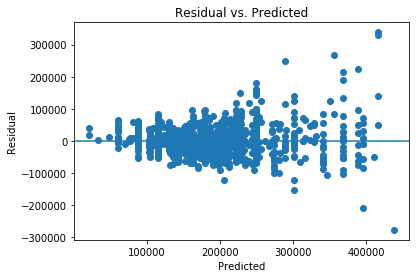

In [477]:
#scatter plot to show the relation
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

OBS:
- it looks like the distribution of residuals over predicted is consistent and doesn't look under overconfidence

#### Checking for heteroscedasticity in the error terms:
- Null Hypothesis is that the errors are homoscedastic:

In [478]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 319.78 and p value is 1.62e-71
Levene test statistic value is 265.113 and p value is 4.03e-57


OBS:
- The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

#### Checking for the assumption five: error terms should be uncorrelated with one another:

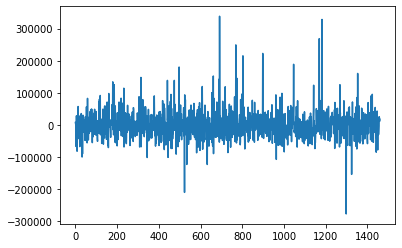

In [479]:
plt.plot(errors)
plt.show()

OBS:
- Error terms doesn't look correlated to each other, as we can see the randomness of graph.

#### Checking for Normality of errors:

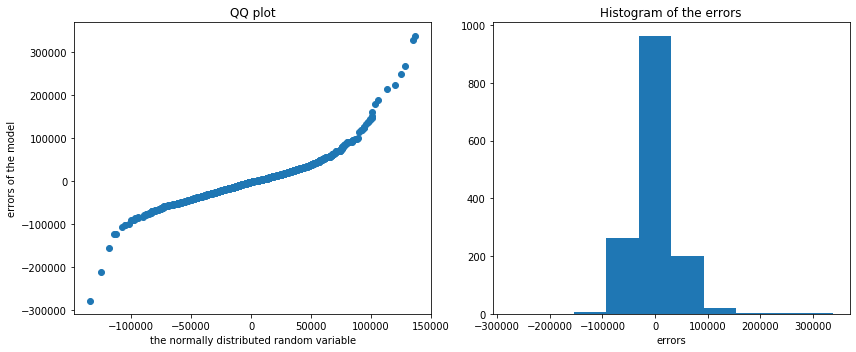

In [480]:
#randomly distributed numbers
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

#figure plotting
plt.figure(figsize=(12,5))

#subplotting figures
plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

OBS:
- Looks almost normal butis not normally distrubuted.

#### Using Jarque Bera and normal tests to see normality:
- Null hypothesis is errors are normally distributed:

In [481]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 7073.117788874167 and p value is 0.0
Normality test statistics is 524.0575017499021 and p value is 1.5935268849538672e-114


OBS:
- So error are not normally distributed from the result, as p-value is lower than 0.05.

### Interpretation of estimated coefficients:

#### Using OLS for linear regression:

In [482]:
# We need to manually add a constant
# in statsmodels' sm
X2 = sm.add_constant(X2)

results = sm.OLS(Y, X2).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     628.5
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:06:01   Log-Likelihood:                -17610.
No. Observations:                1460   AIC:                         3.523e+04
Df Residuals:                    1453   BIC:                         3.527e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8843.9150   8061.776      1.097      0.273   -6970.048    2.47e+04
overallqual       2.745e+04   1188.826     23.092      0.000    2.51e+04    2.98e+04
fireplaces        2.119e+04   1870.722     11.325      0.000    1.75e+04    2.49e+04
garagefinish_Unf -1.506e+04   2661.184     -5.659      0.000   -2.03e+04   -9838.675
kitchenqual_TA   -1.632e+04   2684.656     -6.080      0.000   -2.16e+04   -1.11e+04
kitchenqual_Ex      3.9e+04   5268.708      7.402      0.000    2.87e+04    4.93e+04
bsmtqual_Ex       5.158e+04   4931.813     10.458      0.000    4.19e+04    6.13e+04
==============================================================================
Omnibus:                      524.058   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7073.118
Skew:                           1.285   Prob(JB):                         0.00
Kurtosis:                      13.472   Cond. No.                         49.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OBS:
- Equation for the house price is,

price = 8843.9150 + 2.745e+04	overallqual + 2.119e+04	 fireplaces + -1.506e+04 garagefinish_Unf + -1.632e+04 kitchenqual_TA + 3.9e+04 kitchenqual_Ex	+ 5.158e+04 bsmtqual_Ex - controlled experiment
- From above, we can see that, for higher quality price will increase by 2.745e+04, for house with fireplace price increases by 2.119e+04, Unfinished garage lower the sale price by -1.506e+04, as well as kitchen quality with TA decrease price by -1.632e+04 and for higher quality of basement price increases by  5.158e+04, whcih is the highest among other variables.
- p-value of all the variables is around 0, which means they all are statistically significant to target.
- As t-value is higher for overallquality, which means the differences is higher for this variable than others.
- Standard error high for all.
- Model is skewed to right.

- Here R2 = 0.722, Adjusted R2 = 0.721.
- F-statistic: 628.5 and p- value is 0.
- AIC: 3.523e+04
- BIC: 3.527e+04
- AIC and BIC lower the better, which looks high.

#### Checking for an Interaction terms:
We can make interaction between totrmsabvgrd, fireplaces and kitchenqual_Ex to see if house price is increasing because of total rooms above ground , availability of fireplace and kitchen quality.

In [483]:
Y = houses_c['saleprice']

houses_c['totrmsabvgrd_fireplaces_kitchenqual_Ex'] = houses_c['totrmsabvgrd'] * houses_c['fireplaces']*houses_c['kitchenqual_Ex']
# X is the feature set which includes
# overallqual, totrmsabvgrd, bsmtqual_Ex and totrmsabvgrd_fireplaces_kitchenqual_Ex
X3 = houses_c[["overallqual",  "totrmsabvgrd", "bsmtqual_Ex", "totrmsabvgrd_fireplaces_kitchenqual_Ex"]]

# We add a constant to the model as it's a best practice
# to do so every time!
X3 = sm.add_constant(X3)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X3).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     955.3
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:06:01   Log-Likelihood:                -17604.
No. Observations:                1460   AIC:                         3.522e+04
Df Residuals:                    1455   BIC:                         3.524e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
const                                  -8.923e+04   6272.298    -14.226      0.000   -1.02e+05   -7.69e+04
overallqual                             3.247e+04    977.015     33.231      0.000    3.06e+04    3.44e+04
totrmsabvgrd                            1.007e+04    756.338     13.314      0.000    8586.625    1.16e+04
bsmtqual_Ex                             4.793e+04   4854.510      9.874      0.000    3.84e+04    5.75e+04
totrmsabvgrd_fireplaces_kitchenqual_Ex  3908.4843    455.450      8.582      0.000    3015.076    4801.892
==============================================================================
Omnibus:                      305.984   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6788.365
Skew:                           0.373   Prob(JB):                         0.00
Kurtosis:                      13.537   Cond. No.                         55.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OBS:
- New equation for houses price is:
   
   **price** = -8.923e+04 + 3.247e+04	 overallqual	+ 1.007e+04 totrmsabvgrd + 4.793e+04 bsmtqual_Ex + 3908.4843 totrmsabvgrd_fireplaces_kitchenqual_Ex	
- Constant of -8.923e+04 price, for overall quality price increases by 3.247e+04, for quality of basement price increases by 4.793e+04, for houses with room above ground increases by  1.007e+04, and houses with firplaces, good kitchen quality and number of room above ground increases price by 3908.4843.
- t value is lower for new variable, which means it is more close to target than the previous one. 
- p-value is 0 for all.
- skewness went little down than before.
- std error is high.

- Here R2 = 0.724, Adjusted R2 = 0.723, which is higher than first model.
- F-statistic: 955.3 and p- value around is 0.
- AIC: 3.522e+04
- BIC: 3.524e+04
- AIC and BIC lower the better, which is lower than first model.

#### Changing interaction terms:
Will use overallqual and totrmsabvgrd to get an interaction term, and only use new variable, totrmsabvgrd, and bsmtqual_Ex for OLS:

In [484]:
Y = houses_c['saleprice']

houses_c['totrmsabvgrd_overallqual'] = houses_c['totrmsabvgrd'] * houses_c['overallqual']
# X is the feature set which includes
# overallqual, totrmsabvgrd, and bsntqual_Ex
X4 = houses_c[["totrmsabvgrd", "bsmtqual_Ex", "totrmsabvgrd_overallqual"]]

# We add a constant to the model as it's a best practice
# to do so every time!
X4 = sm.add_constant(X4)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X4).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     1319.
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:06:01   Log-Likelihood:                -17585.
No. Observations:                1460   AIC:                         3.518e+04
Df Residuals:                    1456   BIC:                         3.520e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.014e+05   4866.768     20.845      0.000    9.19e+04    1.11e+05
totrmsabvgrd             -2.047e+04   1304.739    -15.691      0.000    -2.3e+04   -1.79e+04
bsmtqual_Ex               4.979e+04   4573.141     10.887      0.000    4.08e+04    5.88e+04
totrmsabvgrd_overallqual  5128.0326    138.071     37.141      0.000    4857.194    5398.871
==============================================================================
Omnibus:                      281.296   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6627.520
Skew:                           0.192   Prob(JB):                         0.00
Kurtosis:                      13.431   Cond. No.                         207.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OBS:
- price = 1.014e+05 + -2.047e+04 totrmsabvgrd + 4.979e+04 bsmtqual_Ex + 5128.0326 totrmsabvgrd_overallqual
- constant of 1.014e+05 which is positive, -2.047e+04 price down, which shows no dependency to overallqual, basement quality increase price by  4.979e+04 and overallqual with totrmsabvgrd increases price by 5128.0326, overallquality is dependent to totrmsabvgrd.
- t value is high for new variable showing lots of variance.
- p value is 0 for all.
- skewness went down and near to normal distribution than before.


- Here R2 = 0.731, Adjusted R2 = 0.731, which higher than first and second model.
- F-statistic: 1319 and p-value is 0.
- AIC: 3.518e+04
- BIC: 3.520e+04
- AIC and BIC lower the better, which is lower than first and second model.

#### Choosing the best model from above:

- From all the results, we can see that third model looks better than other two, because of higher Adjusted R2, and lower AIC and BIC.
- Actually, there is no big difference in between three models, we can evaluate the performance and see which one would have better accuracy and lower error.

### Splitting data to train and test sets:

In [485]:
#importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [486]:
#splitting data inti test and train sets
X_train, X_test, y_train, y_test = train_test_split(X4, Y, test_size = 0.2, random_state = 465)

#printing the observations
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [487]:
X_train.head()

,const,totrmsabvgrd,bsmtqual_Ex,totrmsabvgrd_overallqual
151,1.0,5,0,25
262,1.0,10,1,80
1037,1.0,7,0,56
1183,1.0,5,0,25
933,1.0,6,0,42


We add a constant to the model, the “baseline” of the data in case all of your features values are 0.

In [488]:
X_train = sm.add_constant(X_train)

#### Training the model :

In [489]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     1049.
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:06:05   Log-Likelihood:                -14061.
No. Observations:                1168   AIC:                         2.813e+04
Df Residuals:                    1164   BIC:                         2.815e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

OBS:
- train model with 80% of data, shows skweness to left, AIC and BIC is lower, F-Stat is higher with p-value of 0.

Making prediction by using predict() function:

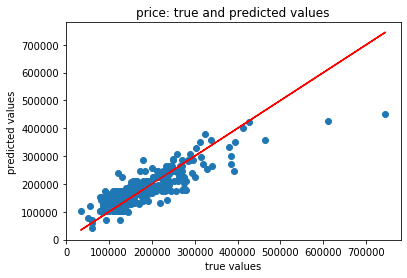

R-squared of the model in the training set is: 0.7300146500355934
-----Test set statistics-----
R-squared of the model in the test set is: 0.7313281132743383
Mean absolute error of the prediction is: 29476.64737946994
Mean squared error of the prediction is: 1803783541.8424258
Root mean squared error of the prediction is: 42470.97293260923
Mean absolute percentage error of the prediction is: 18.009184663525748
OLS Accuracy: 0.67 (+/- 0.14)


In [490]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)

score = cross_val_score(lrm, X_test, y_test, cv=5)


#plotting scatter
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("price: true and predicted values")
plt.show()

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

print("OLS Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

OBS:
- we see that our model predicts most of the values of the target better. 
- Mean absolute error of the prediction is: 29476.64737946994
- Mean squared error of the prediction is: 1803783541.8424258
- Root mean squared error of the prediction is: 42470.97293260923
- Mean absolute percentage error of the prediction is: 18.009184663525748
- Higher errors.

This model looks better as values are more towards red line and R squared of the model looks almost same. Accuracy of 0.67.


### Overfitting and regularization:
- Sometime training model overfitted/underfitted and test model won't do better.
- So we need to do some regularization to solve overfitting problem of the model.
- regularization refers to the process of modifying algorithms in order to lower the generalization gap without sacrificing training performance.
- to modify this function we can use:
  - Ridge, Lasso, and ElasticNet regression 

#### Ridge regression: to deal with the overfitting:


In [491]:
#importing library
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

#to find best alphas to use for regression
alphas = [1e-6, 1e-3, 1e-1, 0, 0.1, 1, 5, 1e3, 1e4,1e6]
ridge_cv = RidgeCV(alphas=alphas, cv=5)

#fit the model
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.7300146150316462
-----Test set statistics-----
R-squared of the model in test set is: 0.7312888441245665
Mean absolute error of the prediction is: 29478.301982928107
Mean squared error of the prediction is: 1804047183.293431
Root mean squared error of the prediction is: 42474.07660318739
Mean absolute percentage error of the prediction is: 18.00980057470881


#### Finding cross validation score with score std:

In [492]:
score = cross_val_score(ridge_cv, X_test, y_test, cv=5)
print("Ridge Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Ridge Accuracy: 0.67 (+/- 0.13)


Observation:
- R2 And Adj R2 looks same for both traina nd test data and same as previous model
- RMSE is lower fro Ridge model than OLS model.
- Accuracy is same as previous model.
- alpha of 0.1.
- Better than previous.

#### Lasso regression:

In [493]:
#using lasso regression
#using same alphas value as before
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 5.0
R-squared of the model in training set is: 0.7300145864257912
-----Test set statistics-----
R-squared of the model in test set is: 0.7312717263118855
Mean absolute error of the prediction is: 29478.792142748513
Mean squared error of the prediction is: 1804162107.222252
Root mean squared error of the prediction is: 42475.42945306441
Mean absolute percentage error of the prediction is: 18.009876931448442


#### Finding cross validation score with score std:

In [494]:
score = cross_val_score(lasso_cv, X_test, y_test, cv=5)
print("Lasso Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Lasso Accuracy: 0.66 (+/- 0.15)


Observation:
- R2 and Adj R2 is same and same as before.
- RMSE is higher than before.
- Accuracy is little lower than previous model.
- alpha is higher which is 5
- Still Ridge is better.

#### ElasticNet regression:

In [496]:
#using elasticnetCV
#using same alphas
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

#fitting the model
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.001
R-squared of the model in training set is: 0.7300134730589185
-----Test set statistics-----
R-squared of the model in test set is: 0.7310994908981138
Mean absolute error of the prediction is: 29486.72981027348
Mean squared error of the prediction is: 1805318444.8222528
Root mean squared error of the prediction is: 42489.039113896804
Mean absolute percentage error of the prediction is: 18.01295227355136


#### Finding cross validation score with score std:

In [497]:
score = cross_val_score(elasticnet_cv, X_test, y_test, cv=5)
print("ElasticNet Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

ElasticNet Accuracy: 0.65 (+/- 0.13)


OBS:
- R2 and Adj R2 is same and same as previous model
- RMSE is higher than other model
- best alpha used is 0.001 which is good, but accuracy of 0.65 which is lower than previous models.
- From all the regularization parameters, OLS, lasso and ridge, OLS and Ridge regression both got about same R2, accuracy and lower error than other model.
- The differences is not much but still Ridge regression got little lower error, so It is the better model than others.

- There is lots of other external features that might help housing price to go up and down, like economics, interest rate, demographics, supply and demands, etc. Here I am going to see if there is correlation between personal income and salesprice going up? 

### Loading new data:

In [498]:
#reading csv file

income = pd.read_csv('Personal_Income_and_Per_Capita_Personal_Income_by_Quarter_in_Iowa.csv') #reading csv file
income.head()


,Date Quarter Ending,Personal Income (Millions of Dollars),Quarterly Population Estimate (Persons),Per Capita Personal Income
0,03/31/1948,3900,NaN,NaN
1,06/30/1948,4203,NaN,NaN
2,09/30/1948,4259,NaN,NaN
3,12/31/1948,4130,NaN,NaN
4,03/31/1949,3680,NaN,NaN


### Info:

In [499]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 4 columns):
Date Quarter Ending                        286 non-null object
Personal Income (Millions of Dollars)      286 non-null int64
Quarterly Population Estimate (Persons)    38 non-null float64
Per Capita Personal Income                 38 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 9.0+ KB


Onservation:
- 4 columns and 286 rows.
- dtypes = float, int, and object.
- memory 9+ kb
- date dtype is object need to change to int.

### New columns with year and personal income from 2006 - 2010 only:
Looking for data on this period of time for personal income for correlation to saleprice of housing.

In [500]:
#Changing date into year
income['year'] = pd.DatetimeIndex(income['Date Quarter Ending']).year

#dropping date now as we have year that was needed
income.drop(['Date Quarter Ending'], axis = 1, inplace = True)

In [501]:
#Data with new columns
income.drop(['Quarterly Population Estimate (Persons)', 'Per Capita Personal Income'], axis = 1, inplace= True)
income.head()

,Personal Income (Millions of Dollars),year
0,3900,1948
1,4203,1948
2,4259,1948
3,4130,1948
4,3680,1949


In [502]:
income_c = income[income['year'].between(2006, 2010)]
income_c

,Personal Income (Millions of Dollars),year
232,100773,2006
233,102021,2006
234,102723,2006
235,104275,2006
236,107730,2007
237,109465,2007
238,110145,2007
239,112285,2007
240,115382,2008
241,118603,2008


### Looking at our previous model of house price:

In [503]:
houses_p = houses_c[["saleprice", "yrsold", "totrmsabvgrd", "bsmtqual_Ex", "totrmsabvgrd_overallqual"]]
houses_p

,saleprice,yrsold,totrmsabvgrd,bsmtqual_Ex,totrmsabvgrd_overallqual
0,208500,2008,8,0,56
1,181500,2007,6,0,36
2,223500,2008,6,0,42
3,140000,2006,7,0,49
4,250000,2008,9,0,72
5,143000,2009,5,0,25
6,307000,2007,7,1,56
7,200000,2009,7,0,49
8,129900,2008,8,0,56
9,118000,2008,5,0,25


In [504]:
#renaming yrsold to year

houses_p.rename(index=str, columns={'yrsold':'year'}, inplace=True)

### Merging two datasets(houses_p and income_c) to one dataset:

In [505]:
#merging
houseprice_inc = pd.merge(houses_p, income_c)

In [506]:
#checking merged data
houseprice_inc .head()

,saleprice,year,totrmsabvgrd,bsmtqual_Ex,totrmsabvgrd_overallqual,Personal Income (Millions of Dollars)
0,208500,2008,8,0,56,115382
1,208500,2008,8,0,56,118603
2,208500,2008,8,0,56,116212
3,208500,2008,8,0,56,115292
4,223500,2008,6,0,42,115382


### Correlation between new datasets:

In [507]:
houseprice_inc.corr()

,saleprice,year,totrmsabvgrd,bsmtqual_Ex,totrmsabvgrd_overallqual,Personal Income (Millions of Dollars)
saleprice,1.000000,-0.028923,0.533723,0.553105,0.798465,-0.026488
year,-0.028923,1.000000,-0.034516,-0.001321,-0.036284,0.803651
totrmsabvgrd,0.533723,-0.034516,1.000000,0.240581,0.846768,-0.030883
bsmtqual_Ex,0.553105,-0.001321,0.240581,1.000000,0.447110,-0.012727
totrmsabvgrd_overallqual,0.798465,-0.036284,0.846768,0.447110,1.000000,-0.029649
Personal Income (Millions of Dollars),-0.026488,0.803651,-0.030883,-0.012727,-0.029649,1.000000


Observation:
- We can see that, year and personal income is not highly correlated to saleprice.
- Its may be becasue we missed valuable information about neighborhod, could have better correlation if saleprice of different neighborhood were matched to personal income of that neighborhood.
- But looking at one city, Ames city there is no correlation between saleprice and personal income.
- we can see that personal income and year is highly correlated to eachother though.

### Training model and Predicting model:

In [508]:
#Target feature
Y = houseprice_inc['saleprice']

#other features except year, only adding one feature
X = houseprice_inc[["totrmsabvgrd", "bsmtqual_Ex", "totrmsabvgrd_overallqual", "Personal Income (Millions of Dollars)"]]




In [509]:
#splitting data inti test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

#printing the observations
print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 4672
The number of observations in test set is 1168


#### Using OLS model for regression:

In [510]:
#training model
X_train = sm.add_constant(X_train)
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     3395.
Date:                Fri, 07 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:15:32   Log-Likelihood:                -56187.
No. Observations:                4672   AIC:                         1.124e+05
Df Residuals:                    4667   BIC:                         1.124e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Observation:
- p-value of personal income is really high.
- R2 and Adj R2 is same 0.744
- lower AIC and BIC

### Predicting model now:

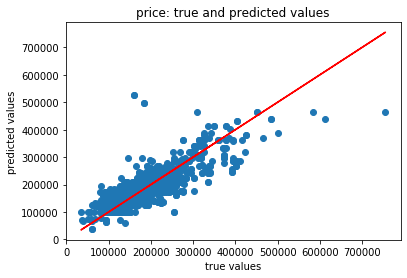

R-squared of the model in the training set is: 0.7442144044262431
-----Test set statistics-----
R-squared of the model in the test set is: 0.6730355001550383
Mean absolute error of the prediction is: 29619.963334815104
Mean squared error of the prediction is: 1948181698.3673906
Root mean squared error of the prediction is: 44138.21131816955
Mean absolute percentage error of the prediction is: 17.816271006890684
OLS Accuracy: 0.68 (+/- 0.06)


In [511]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


#to find accuracy
score = cross_val_score(lrm, X_test, y_test, cv=5)


#plotting scatter
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("price: true and predicted values")
plt.show()

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))
print("OLS Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


Observation:
- R2 of train model is 0.744 and R2 of test model is 0.67, which looks like the model is overfitted.
- Before adding external variables, R2 of both train and test data were same on 0.73, and values were toward red line.
- There was no multicollinearity in previous model.
- Eventhough personal income had no correlation to any other features, the model showed multicollinearity, may be becasue of some numerical problems.
- MAE, MSE, RMSE is higher and MAPE is lower for this model.


## Conclusion:

- From Data exploration I could see that, sale price looks highly correlated to overallqual, yearbuilt, yearrremodadd, masvnarea, bsmtfinsf1, totalbsmtsf, firstflrsf, grlivarea, fullbath, totrmsabvgrd, fireplaces, garageyrblt, garagecars, garagearea but also overallqual is correlated to yearbuilt, yearrremodadd, totalbsmtsf, firstflrsf, grlivarea, fullbath, garagecars, garagearea.
- masvnarea, fireplaces were not highly correlated to other features. So I decided to use Overallqual, masvnarea, and fireplaces for modelling.
- After feature Engineering, through Correlation Matrix I found out that,overallqual, yearbuilt, yearremodadd, grlivarea, totalbsmtsf, firstflrsf, fullbath, totrmsabvgrd, garagecars, garagearea, bsmtqual_Ex, exterqual_TA, kitchenqual_Ex, kitchenqual_TA, garagefinish_Unf have correlation higher than 0.5 to sale price.
- First, I used all the highly correlated features to get model using OLS for linear regression, and then I dropped few features with high correlation to each other and added some interaction, and then reimplement my model using different interaction term and changing features to get better model.
- I went through assumption for linearity. 
- I got better model using features: totrmsabvgrd, bsmtqual_Ex, totrmsabvgrd_overallqual.
- And then I splitted my datas to training and testing data and trained the model, and used data for prediction using testing data.
- To get better prediction and minimize overfitting I used Ridge/Lasso/ElasticNet regression.
- Comparing all OLS/Ridge/Lasso/ElasticNet regression, I found that Ridge regression is a better model to predict, because it has RMSE(error) than OLS model. OLS model and Ridge regression had little differences only in error but R2, accuracy, MAPE were same for both. 
- I used external variable of personal income data from Ames city from 2006 to 2010, to see if personal income affects saleprice of house or not?
- But I guess because there was no data about neighborhood I couldn't predict correlation of saleprice and personal income ingiven year fro certain neighborhood which I wanted to look.
- But overall I could see correlation between saleprice and personal income in given year for Ames city.
- Got multicollinearity, and couldn't predict better with this model, may be we can use other models to predict the data more accurately.
